In [1]:
import sklearn
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import r2_score
import numpy as np

In [2]:
import statsmodels.api as sma
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sma.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sma.add_constant(X)
        return self.results_.predict(X)

In [46]:
def create_dose_per_period_lst(freq,range_end):
    lst_dose_per=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_dose_per.append('all_dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_dose_per.append('all_dose_{}m+'.format(st_lab))
    
    return lst_dose_per

In [3]:
def create_Ndose_period_lst(freq,range_end):
    lst_1dose=[]
    lst_2dose=[]
    lst_3dose=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_1dose.append('1dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_1dose.append('1dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_2dose.append('2dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_2dose.append('2dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_3dose.append('3dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_3dose.append('3dose_{}m+'.format(st_lab))
    return lst_1dose,lst_2dose,lst_3dose

In [4]:
def create_overall_period_lst(freq,range_end):
    lst_overall=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_overall.append('overall_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_overall.append('overall_{}m+'.format(st_lab))
    return lst_overall #_1dose,lst_2dose,lst_3dose

In [271]:
from scipy.ndimage import shift
def feature_extraction_vax_per_st(df,Country_lst,use_lst,start_date,end_date,vax_data_freq,st_per):
    #['max_1st_rate','max_2nd_rate','max_3rd_rate']
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
                
        tmp_df[lst_dose_per] = 0 # lst_1dose+lst_2dose+lst_3dose]=0
        tmp_df['total_vaccinations_per_hundred'] = tmp_df['total_vaccinations_per_hundred'].fillna(method='ffill').fillna(int(0))
        tmp_df['total_vaccinations_per_hundred_diff'] = tmp_df['total_vaccinations_per_hundred'].diff().shift(-1)/100
        
        st_dose = tmp_df[tmp_df['total_vaccinations_per_hundred']>st_per]['date'].iloc[0]
        print(Countryname,st_dose) #,st_2dose,st_3dose)
        
        ############### vax_per_period #############
        dict_dose={}
        tmp_lst=[]
        date_lst = tmp_df[(tmp_df['date']>=st_dose) & (tmp_df['total_vaccinations_per_hundred_diff'].notna())]['date'].values #.reset_index(drop=True)
        for d in date_lst:
            st = datetime.strptime(d,'%Y-%m-%d')
            tmp_vax_per_diff = tmp_df[tmp_df['date']==d]['total_vaccinations_per_hundred_diff'].values[0]
            tmp_lst.append(tmp_vax_per_diff)
            for i in range(len(lst_dose_per))[:-1]:
                et = st + relativedelta(months=+vax_data_freq) # + relativedelta(days=+1)
                dict_dose[lst_dose_per[i]] = (str(st)[:10],str(et)[:10])
                #print(st,et)
                tmp_df.loc[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d')),lst_dose_per[i]] = tmp_df[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d'))][lst_dose_per[i]] + tmp_vax_per_diff
                st = et + relativedelta(days=+1)
            et = st + relativedelta(months=+24)
            #print(st,et)
            tmp_df.loc[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d')),lst_dose_per[i+1]] = tmp_df[(tmp_df['date']>datetime.strftime(st,'%Y-%m-%d')) & (tmp_df['date']<=datetime.strftime(et,'%Y-%m-%d'))][lst_dose_per[i+1]] + tmp_vax_per_diff

        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        #print(plt_df['total_vaccinations_per_hundred_diff'].sum())
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        #print(tmp_df['total_vaccinations_per_hundred_diff'].sum())
        #print(plt_df['total_vaccinations_per_hundred_diff'].sum())
        #tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=30,min_periods=1).mean() #,center=True
        #plt_df['last_year_new_deaths_smoothed_1_3m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_4_6m'] = shift(tmp_last_year_cov, 30, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_7_9m'] = shift(tmp_last_year_cov, 60, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_10_12m'] = shift(tmp_last_year_cov, 90, cval=np.NaN) #60
        #plt_df['last_year_new_deaths_smoothed_13_15m'] = shift(tmp_last_year_cov, 120, cval=np.NaN) #60
        tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=90,min_periods=1).mean() #,center=True
        plt_df['last_year_new_deaths_smoothed_1_3m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_4_6m'] = shift(tmp_last_year_cov, 90, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_7_9m'] = shift(tmp_last_year_cov, 180, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_10_12m'] = shift(tmp_last_year_cov, 270, cval=np.NaN) #60
        plt_df['last_year_new_deaths_smoothed_13_15m'] = shift(tmp_last_year_cov, 365, cval=np.NaN) #60

        #tmp_last_year_cov = plt_df['new_deaths_smoothed'].rolling(window=180,min_periods=1).mean() #,center=True
        #plt_df['last_year_new_deaths_smoothed_1m'] = shift(tmp_last_year_cov, 0, cval=np.NaN) #60
        
        plt_df = plt_df[plt_df['date']>=start_date].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        #plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_1_3m_Norm'] = plt_df['last_year_new_deaths_smoothed_1_3m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_4_6m_Norm'] = plt_df['last_year_new_deaths_smoothed_4_6m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_7_9m_Norm'] = plt_df['last_year_new_deaths_smoothed_7_9m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_10_12m_Norm'] = plt_df['last_year_new_deaths_smoothed_10_12m']/plt_df['new_deaths_smoothed'].max()
        plt_df['last_year_new_deaths_smoothed_13_15m_Norm'] = plt_df['last_year_new_deaths_smoothed_13_15m']/plt_df['new_deaths_smoothed'].max()


        #plt_df['last_year_new_deaths_smoothed_1m_Norm'] = plt_df['last_year_new_deaths_smoothed_1m']/plt_df['new_deaths_smoothed'].max()

        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['ex_mortality_Norm'] = (plt_df['excess_mortality']-plt_df['excess_mortality'].min())/(plt_df['excess_mortality'].max() - plt_df['excess_mortality'].min())

        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(dict_1dose,dict_2dose,dict_3dose)
    return new_df

In [6]:
def feature_extraction_overall(df,Country_lst,use_lst,start_date_data,start_date_ref,end_date_data,vax_data_freq):
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
        
        dict_overall={}
        st = datetime.strptime(start_date_ref,'%Y-%m-%d')
        for i in range(len(lst_overall))[:-1]:
            et = st + relativedelta(months=+3) # + relativedelta(days=+1)
            dict_overall[lst_overall[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+1)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_overall[lst_overall[i+1]] = (str(st)[:10],str(et)[:10])

        # labeling catagories
        tmp_df['overall_period']='overall_Null'
        for tmp_period in dict_overall.keys():
            tmp_st=dict_overall[tmp_period][0]
            tmp_et=dict_overall[tmp_period][1]
            tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        one_hot = pd.get_dummies(tmp_df['overall_period'])
        # Drop column 1dose_period as it is now encoded
        tmp_df = tmp_df.drop('overall_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)
        
        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        plt_df = plt_df[plt_df['date']>=start_date_data].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date_data].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(plt_df.tail(50))
    return new_df

In [7]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_new_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    print('[{}] Self-Rmse for {} is : {}\nSelf-R2 is : {}'.format('LR_MDL','All',rmse,r2))
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    std_r2_score = np.std(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error') #neg_root_mean_squared_error  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    std_rmse = np.std(rmse_lst)
    print('Cross-validataion R2 : {}.'.format(r2_score_lst))
    print('\033[1m' + 'Cross-validataion R2 average : {}.'.format(mean_r2_score) + '\033[0m')
    print('\033[1m' + 'Cross-validataion R2 std : {}.'.format(std_r2_score) + '\033[0m')
    print('Cross-validataion mse : {}.'.format(rmse_lst))
    print('\033[1m' + 'Cross-validataion mse average : {}.'.format(mean_rmse) + '\033[0m')
    print('\033[1m' + 'Cross-validataion mse std : {}.'.format(std_rmse) + '\033[0m')

    print(lr_mdl.summary())

    # create result DataFrame
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None)  
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse


In [8]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_silent_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error')  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    #print(lr_mdl.summary())

    # create result DataFrame (62 countries)
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  #result.params[1:]

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None) # result.pvalues[1:] #p_val
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse



In [9]:
def plot_vax_rate(df,Countryname):
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    # fix missing values
    for i in range(1,tmp_df.shape[0]):
        if np.isnan(tmp_df['people_vaccinated_per_hundred'][i]):
            tmp_df['people_vaccinated_per_hundred'][i] = tmp_df['people_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['people_fully_vaccinated_per_hundred'][i]):
            tmp_df['people_fully_vaccinated_per_hundred'][i]= tmp_df['people_fully_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['total_boosters_per_hundred'][i]):
            tmp_df['total_boosters_per_hundred'][i] = tmp_df['total_boosters_per_hundred'][i-1]


    save_path = 'results/Vax_rate/' + Countryname + '/'
    os.makedirs(save_path,exist_ok=True)

    fig_size=(10,5)
    n_dpi=120

    fig,ax = plt.subplots()
    fmt = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt)

    plt.plot(tmp_df['date'],tmp_df['people_vaccinated_per_hundred'],color='green', alpha=0.2)
    plt.plot(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'],color='green', alpha=0.4)
    plt.plot(tmp_df['date'],tmp_df['total_boosters_per_hundred'],color='green', alpha=0.6)
    ax.tick_params(axis='x', labelrotation=45)

    ax.fill_between(tmp_df['date'], tmp_df['people_vaccinated_per_hundred'],0, color='green', alpha=0.2)
    ax.fill_between(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'], 0, color='green', alpha=0.4)
    ax.fill_between(tmp_df['date'], tmp_df['total_boosters_per_hundred'], 0, color='green', alpha=0.6)

    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.legend(['1st_dose_rate','2nd_dose_rate','3rd_dose_rate'],loc='upper left',fontsize=10)
    plt.title('{} Vaccination Rate'.format(Countryname),fontsize=20) 
    plt.tight_layout()
    fig.savefig(' '.join([save_path,'{}_Vaccination_Rate'.format(Countryname)])+str(fig_size)+'.png',facecolor='white', transparent=False) #' '.join([save_path,'【All causes death risk('+EN2CN[sex]+')】',EN2CN[v_status],'VS Unvaccinated'])+str(fig_size)+'.png',facecolor='white', transparent=False)


In [10]:
def cal_ex_death_by_covid_vax(df,lr_mdl,Countryname,mdl_x_lst,s_e,start_date):
    vax_var_lst=mdl_x_lst[s_e[0]:s_e[1]]
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*lr_mdl.params[1] ##.shape
    x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    ex_death_vax = np.dot(lr_mdl.params[s_e[0]+1:s_e[1]+1],x)
    return ex_death_covid,ex_death_vax

In [11]:
from matplotlib.ticker import MaxNLocator
def plt_curve_by_pvalue(x,y_p005,y,outfile,color='royalblue'):
    fig,ax = plt.subplots()
    y_solid = [n if ~np.isnan(n) else np.inf for n in y_p005]
    
    ax.plot(x, y_solid, linestyle="--", lw=.5, color=color,marker='$\u25CC$',markersize=10,markerfacecolor='none',markeredgecolor=color)
    ax.plot(x, y, lw=1,color=color,marker='o',markersize=10)

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticklabels([''] + x +[''])
    n_dpi=180
    fig_size=(7,5)
    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.tick_params(axis='x', labelrotation=45)

    plt.legend(['p > 0.05','p < 0.05'])
    plt.grid()
    plt.tight_layout()
    fig.savefig(outfile, facecolor='white', transparent=False)

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os 
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.rcParams['font.family']='Hiragino Maru Gothic Pro' #'sans-serif' #


In [14]:
# https://covid.ourworldindata.org/data/owid-covid-data.csv
os.makedirs('data',exist_ok=True)
#! curl https://covid.ourworldindata.org/data/owid-covid-data.csv > 'data/owid-covid-data-23XXXX.csv'
in_csv='data/owid-covid-data-230213.csv'
df=pd.read_csv(in_csv,engine='python')

## Hparam selection : filtering out countries with low booster rate (booster_per_th)
create use_Country_lst

In [15]:
vax_rate_dic={}
# 'Sweden','Malta', shows partial record for 3rd dose vaccination rate
#'Sweden','Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles',
#rm_vax_Country_lst = ['Sweden','Brunei','French Polynesia','Malta','Mauritius','Mexico','Mongolia','New Caledonia','Qatar','Seychelles',]

rm_Country_lst = ['Sweden','Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles','Africa','Asia','Europe','European Union','High income','Low income','Lower middle income','North America','South America','Upper middle income','World','Western Sahara','Oceania']
booster_per_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_boosters_per_hundred'].max()>0:
        booster_per_lst.append(tmp_df['total_boosters_per_hundred'].max()) #vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]

booster_per_th = np.median(booster_per_lst)
use_Country_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_boosters_per_hundred'].max() >= booster_per_th :
        vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]
        use_Country_lst.append(Countryname)



In [69]:
booster_per_th,len(use_Country_lst)

(27.38, 96)

# data processing

In [70]:
equatorial_countries=[ 'Brazil', 'Colombia', 'Costa Rica', 'Cuba','Ecuador','Malaysia','Maldives','Panama',
                      'Peru','Singapore','Thailand','Hong Kong'] #
south_countries=['Uruguay','New Zealand','Australia','Paraguay','Chile'] #  

In [71]:
#use_Country_lst=[c for c in use_Country_lst if c not in equatorial_countries and c not in south_countries ]

In [72]:
len(use_Country_lst)

96

## Extract VA-TPAV

In [130]:
st_per=0
freq = 3

# creating labels of catetorical classes
range_end = 12
lst_dose_per=create_dose_per_period_lst(freq,range_end)
print(lst_dose_per)
use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_dose_per + ['total_vaccinations_per_hundred','total_vaccinations_per_hundred_diff']# + lst_2dose + lst_3dose + lst_max_dose_rate
start_date = '2020-12-01'
end_date = '2023-03-31'

new_df = feature_extraction_vax_per_st(df,use_Country_lst,use_lst,start_date,end_date, freq,st_per)




['all_dose_1_3m', 'all_dose_4_6m', 'all_dose_7_9m', 'all_dose_10_12m', 'all_dose_13m+']
Andorra 2021-01-25
1.9568999999999999
1.9568999999999999
1.4685000000000001
****skipping Andorra data for lack of new_deaths_smoothed.
Argentina 2020-12-29
2.517
2.517
0.001
****skipping Argentina data for lack of excess_mortality.
Australia 2021-02-22
2.4327
2.4327
2.4071
Austria 2020-12-27
2.2667
2.2667
2.2667
Azerbaijan 2021-02-06
1.3377999999999999
1.3377999999999999
1.3378
Bahrain 2020-12-23
2.3615
2.3615
0.0
****skipping Bahrain data for lack of excess_mortality.
Bangladesh 2021-02-07
2.0639
2.0639
0.0
****skipping Bangladesh data for lack of excess_mortality.
Belarus 2021-02-18
1.9792
1.9792
0.006999999999999999
****skipping Belarus data for lack of excess_mortality.
Belgium 2020-12-30
2.5409999999999995
2.5409999999999995
2.534
Bermuda 2021-01-16
2.0564999999999998
2.0564999999999998
1.7552000000000003
Bhutan 2021-03-27
2.5707
2.5707
0.0
****skipping Bhutan data for lack of excess_mortality.

## Check where is all_dose_7_9m centered

In [263]:
tmp_lst=[]
for Countryname in new_join_df.location.unique():
    tmp_df=new_join_df[new_join_df['location']==Countryname].reset_index(drop=True)
    tmp_lst.append(tmp_df['date'].astype("datetime64").iloc[tmp_df['all_dose_7_9m'].idxmax()])
    

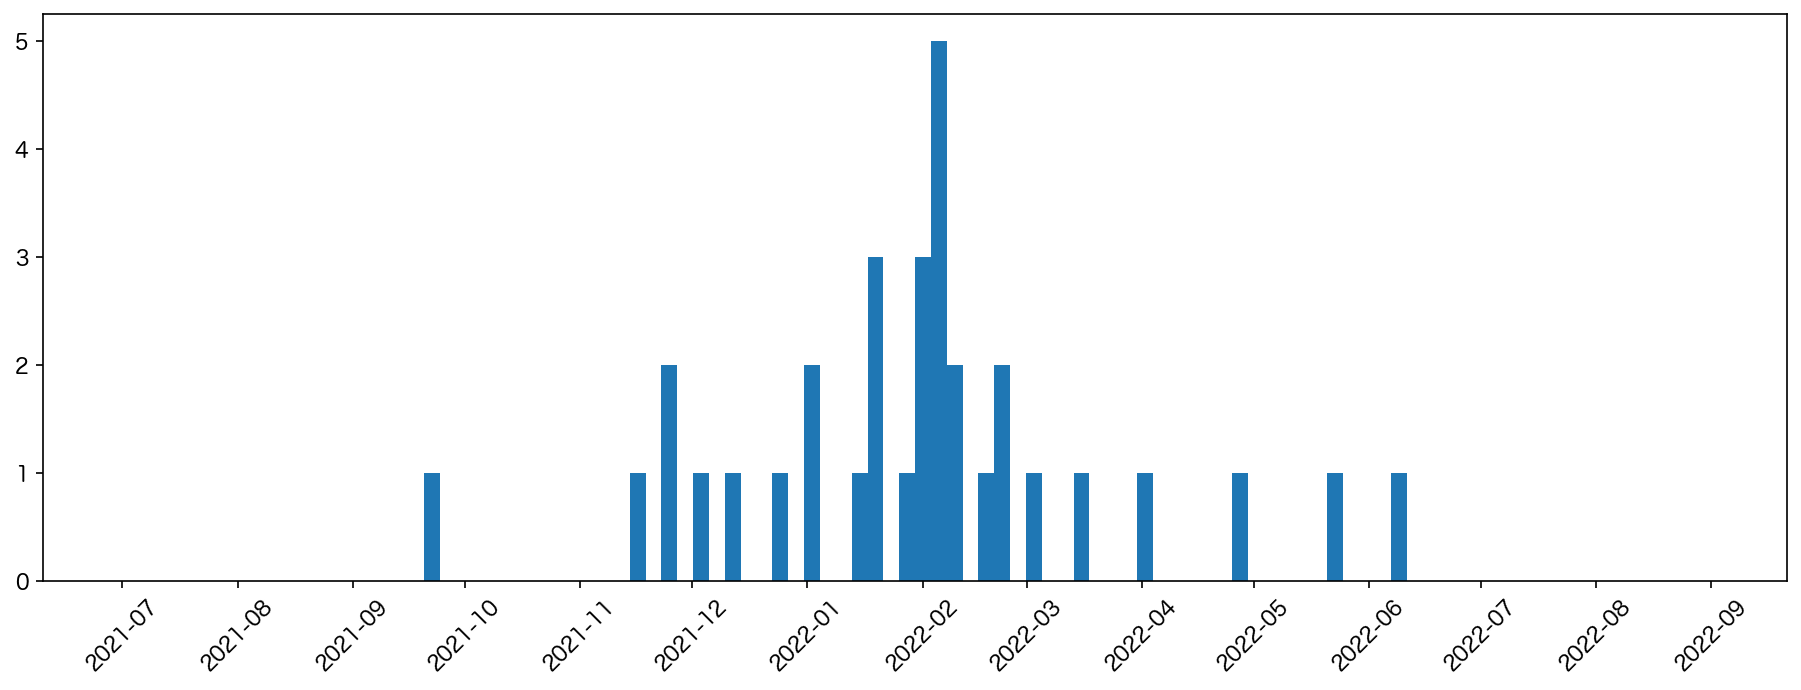

In [270]:
fig,ax = plt.subplots()

plt.hist(tmp_lst,bins=100,range=(dt.strptime('2021-07-01','%Y-%m-%d'),dt.strptime('2022-08-31','%Y-%m-%d')))
ax.xaxis.set_major_locator(fmt)
ax.tick_params(axis='x', labelrotation=45)
fig.set_dpi(150)
fig.set_size_inches(15,5)



### Plot max of all_dose_7_9m

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_53101/2225727311.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


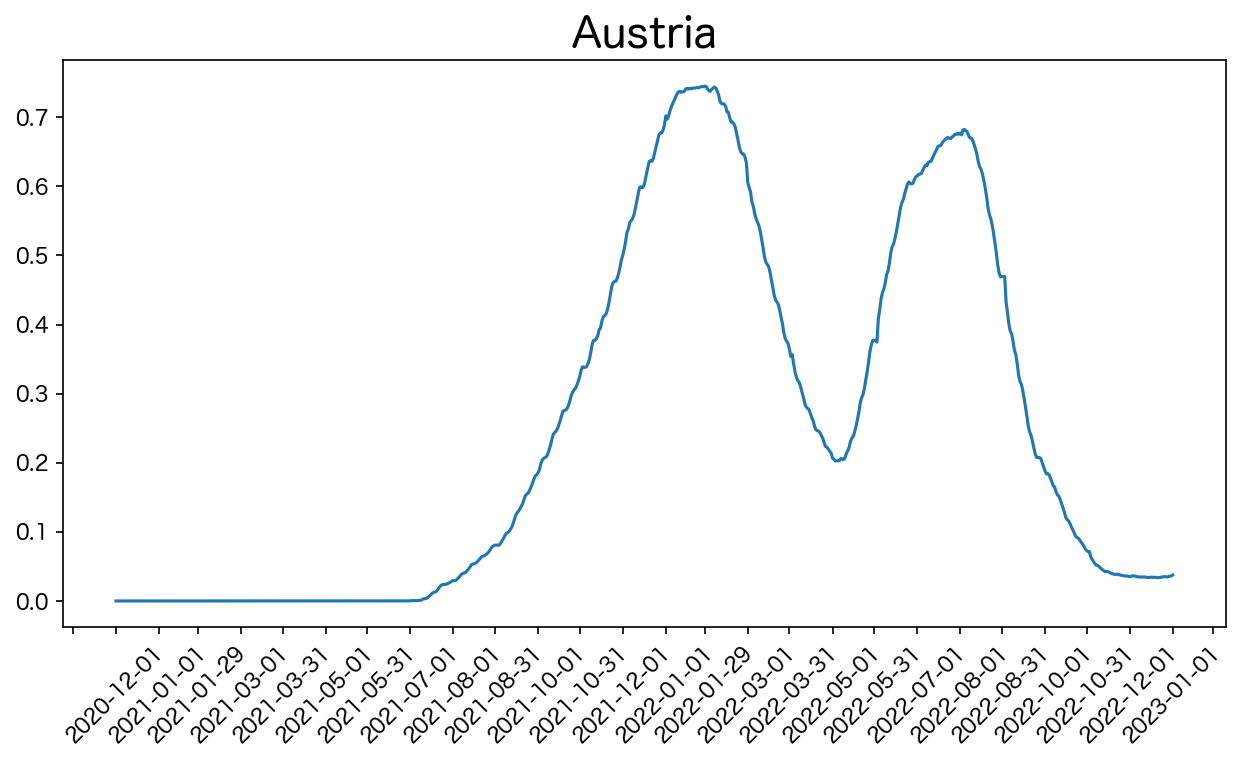

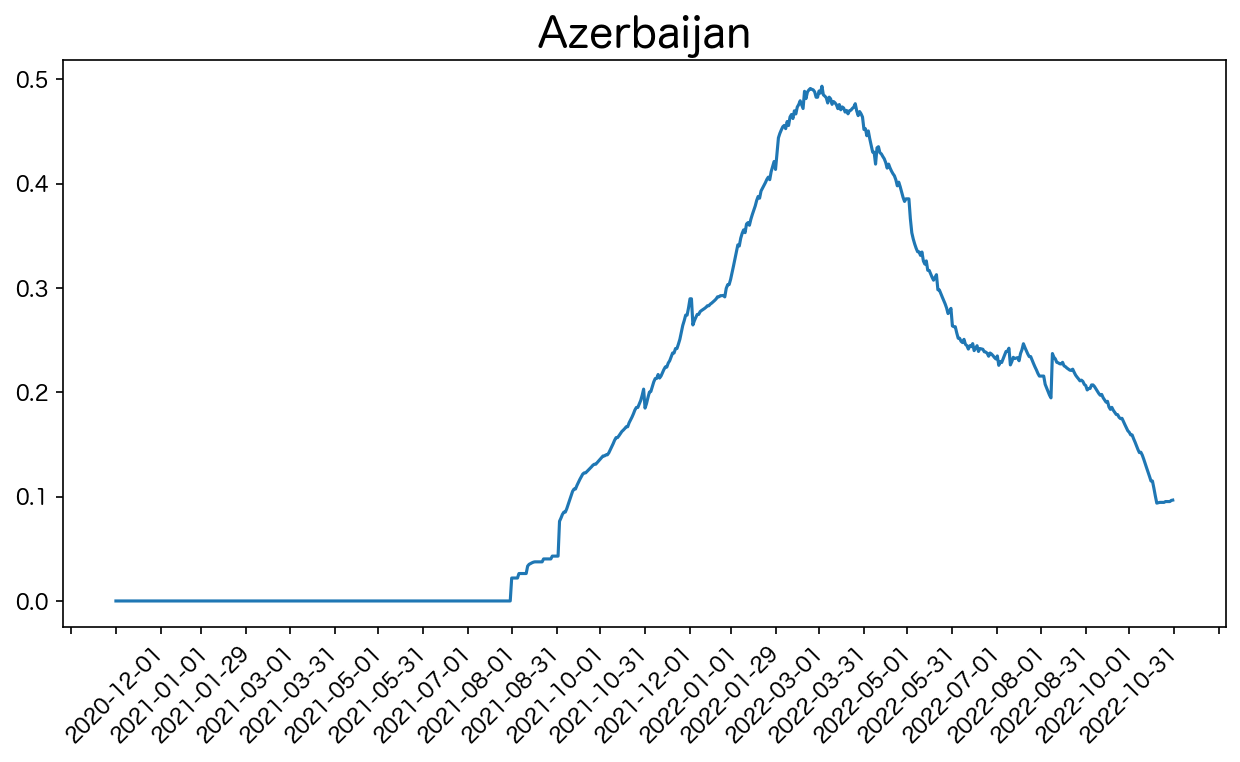

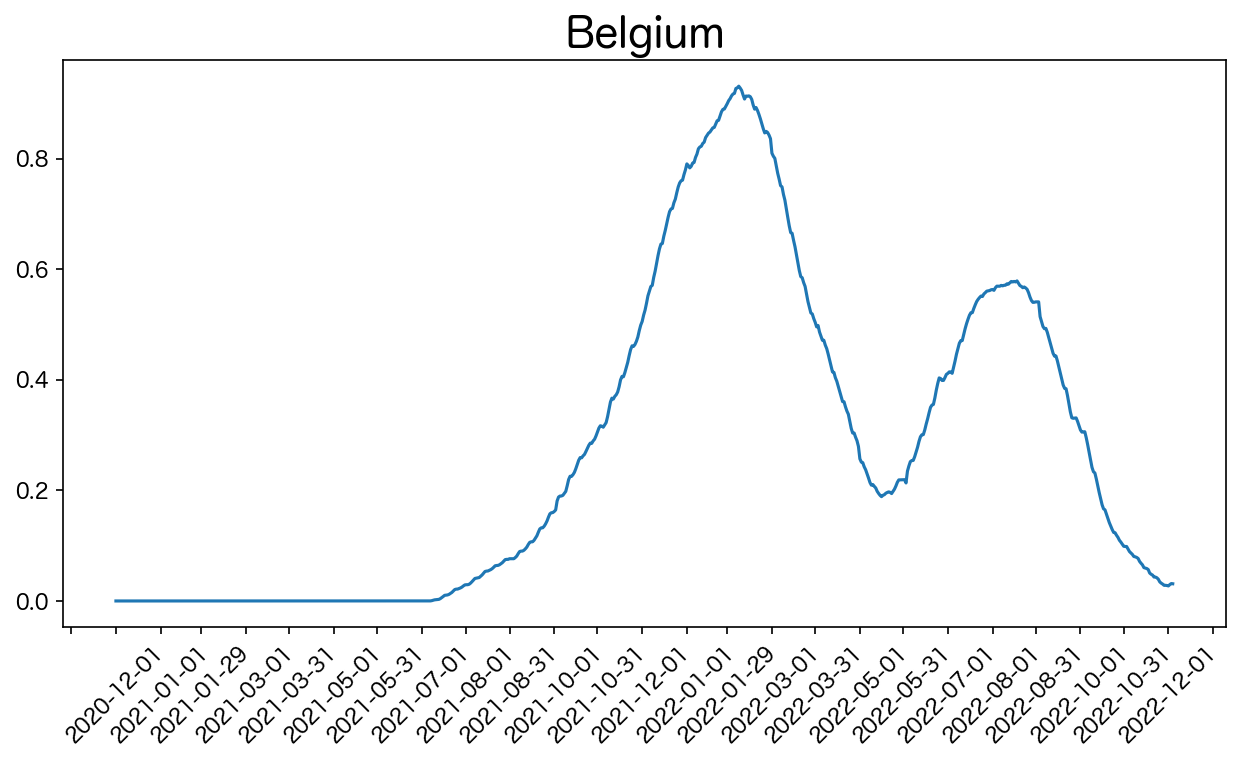

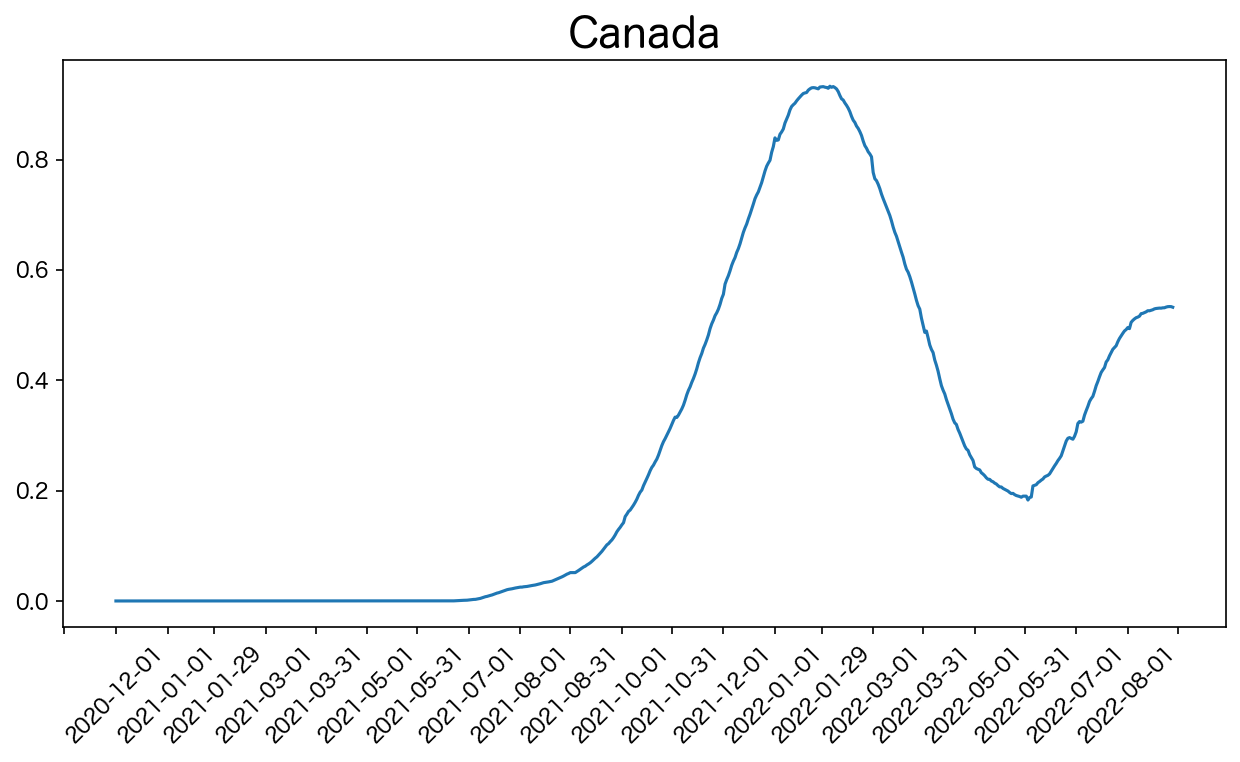

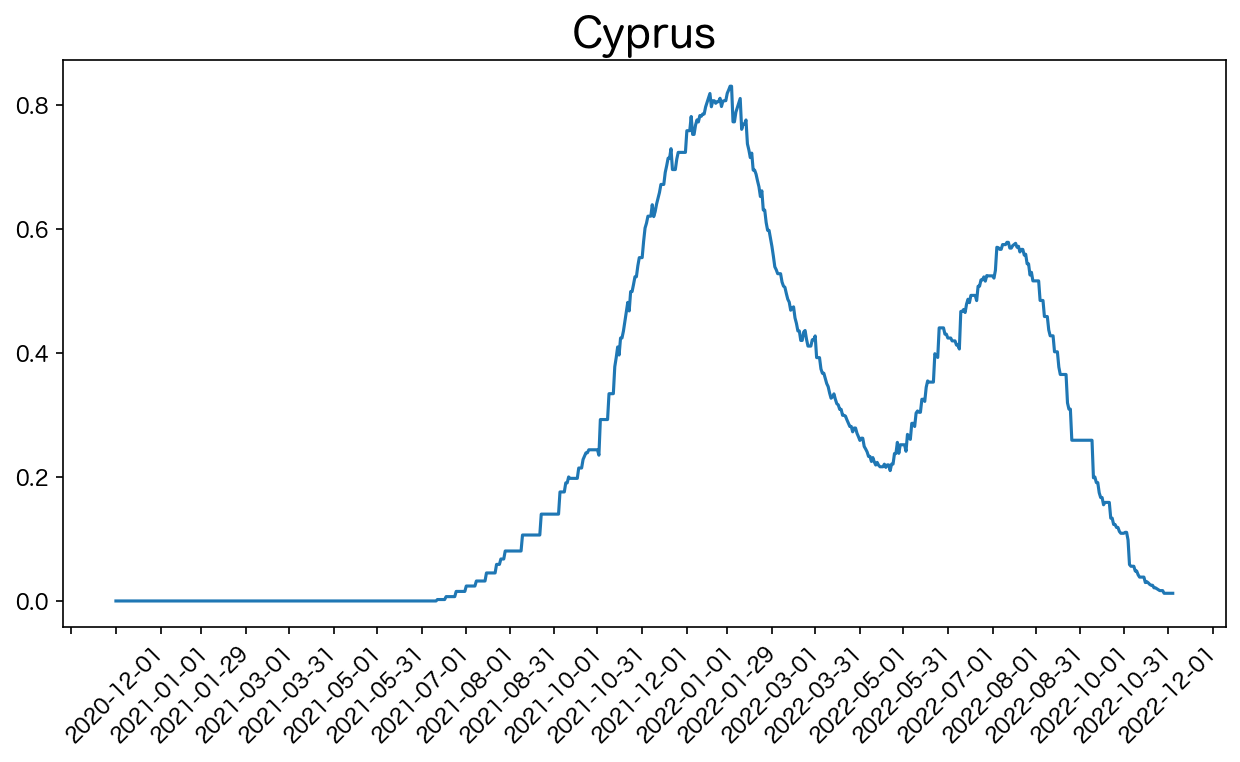

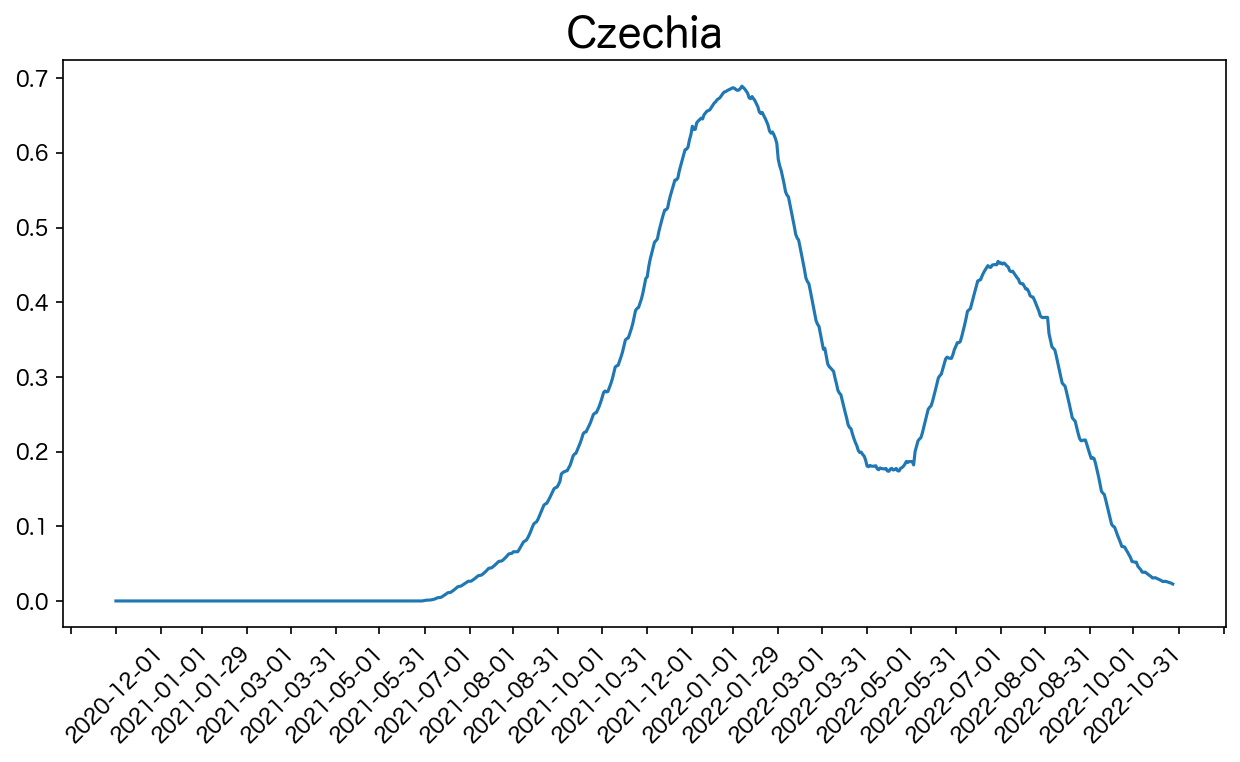

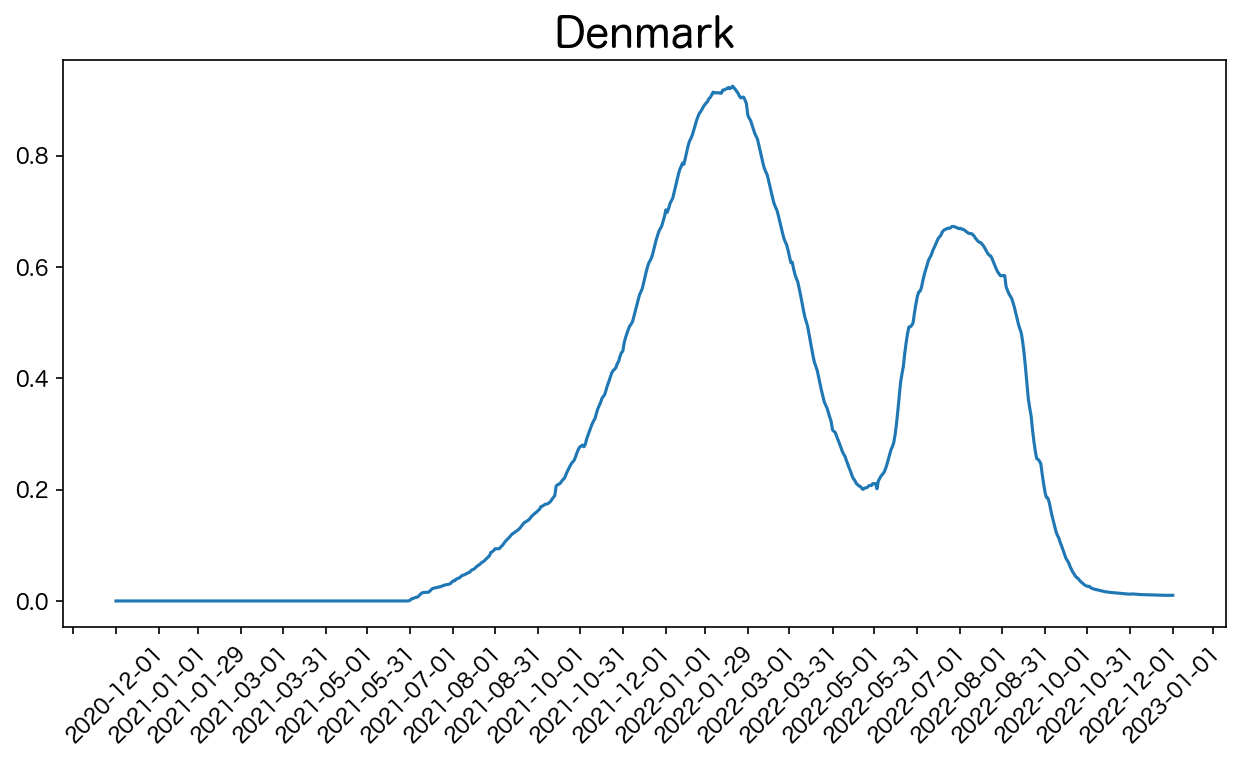

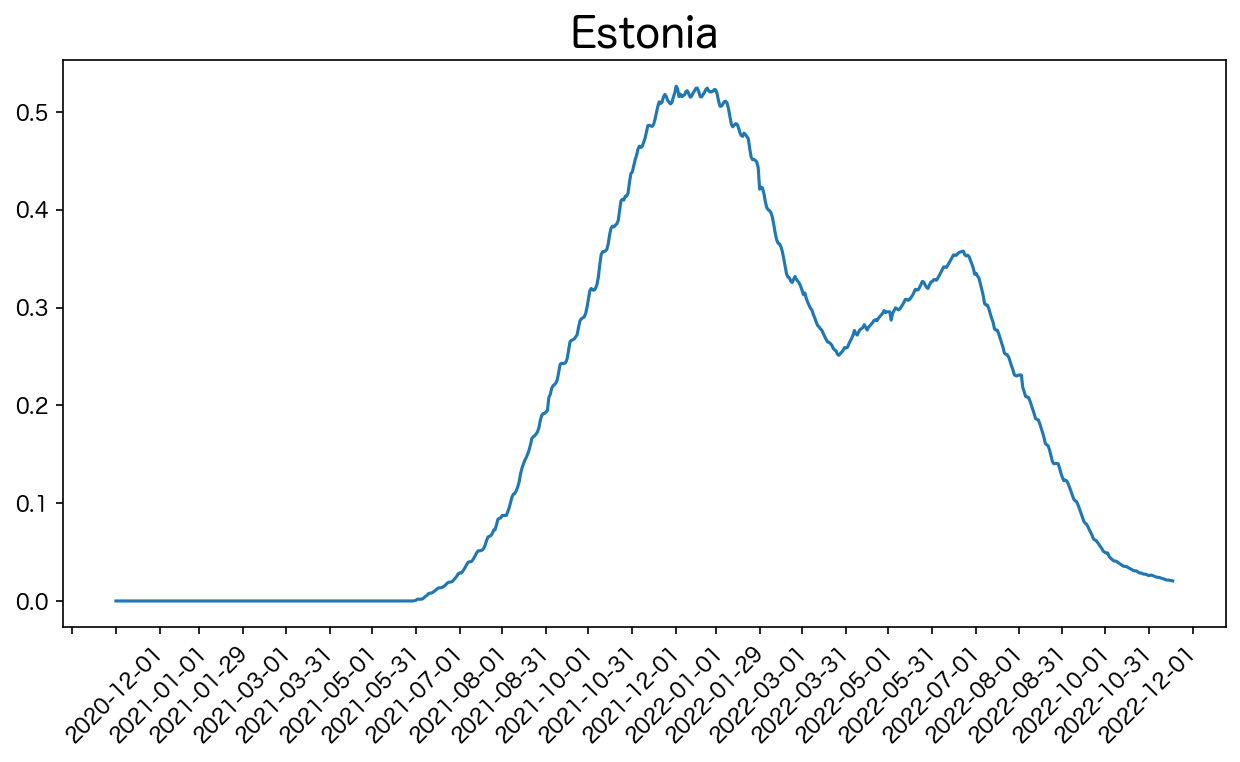

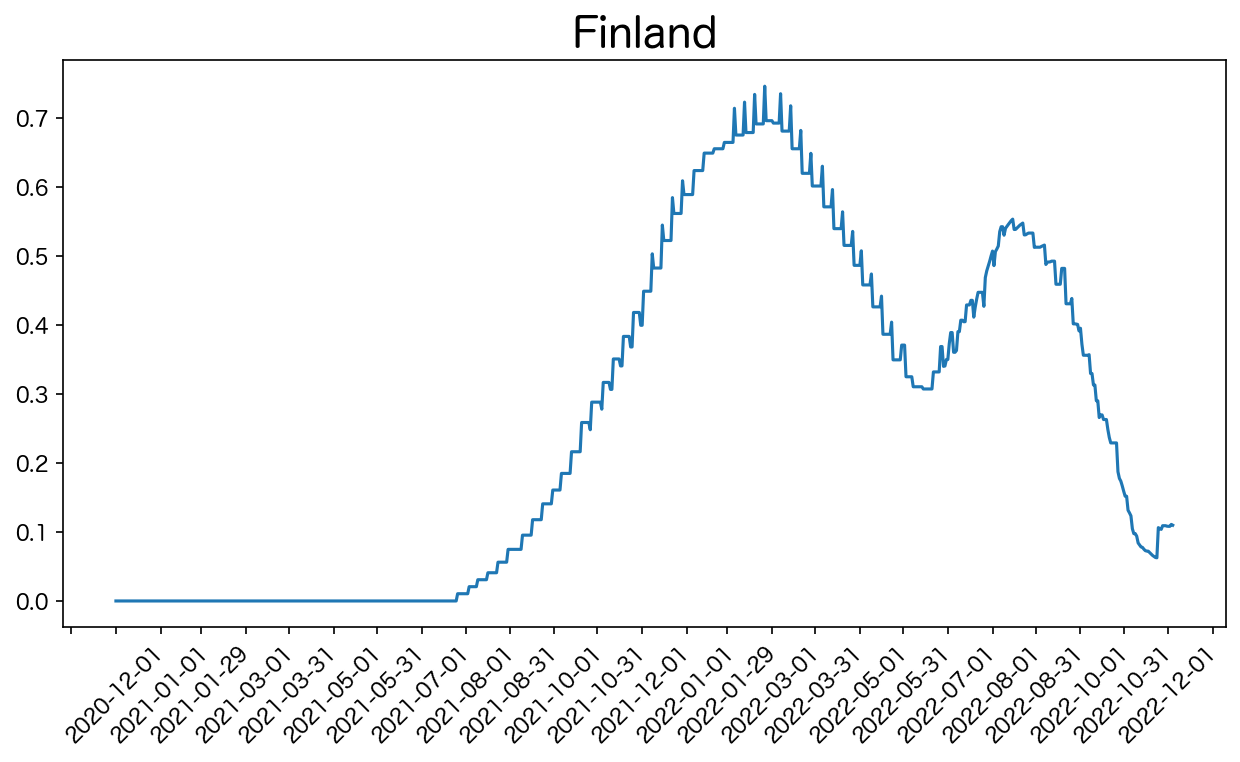

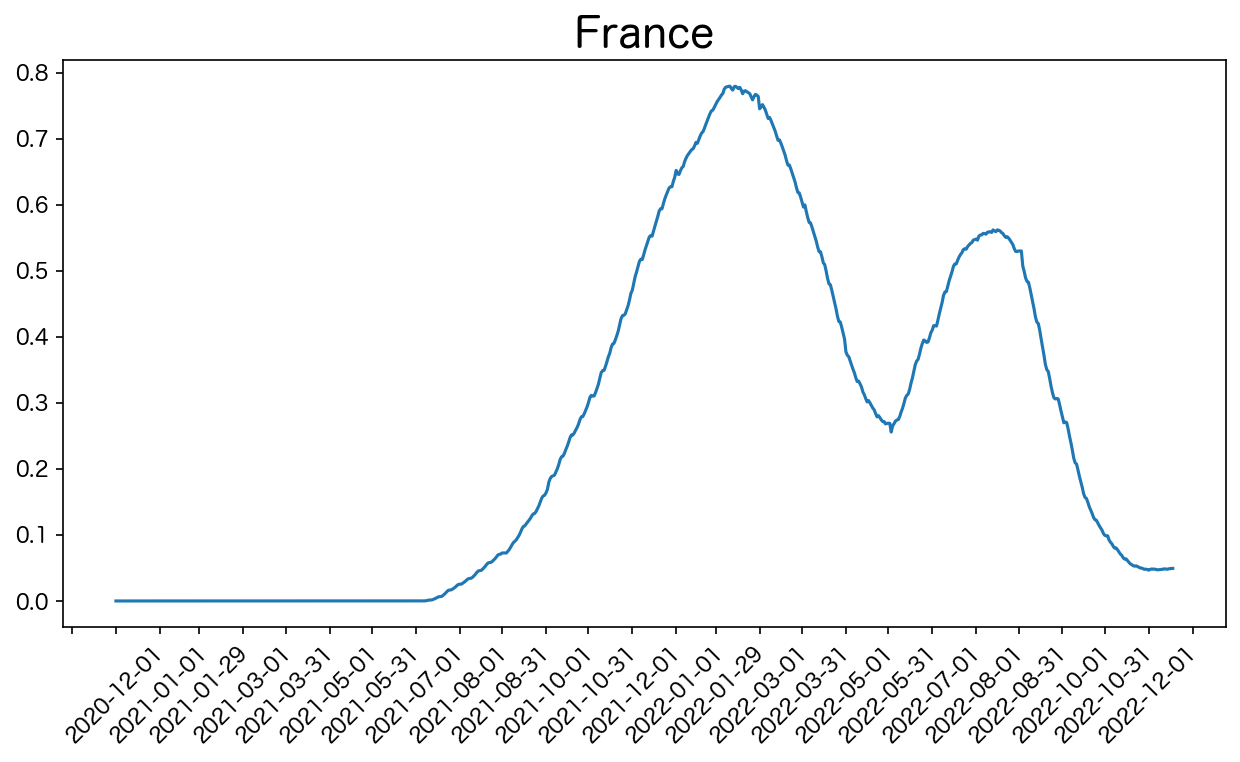

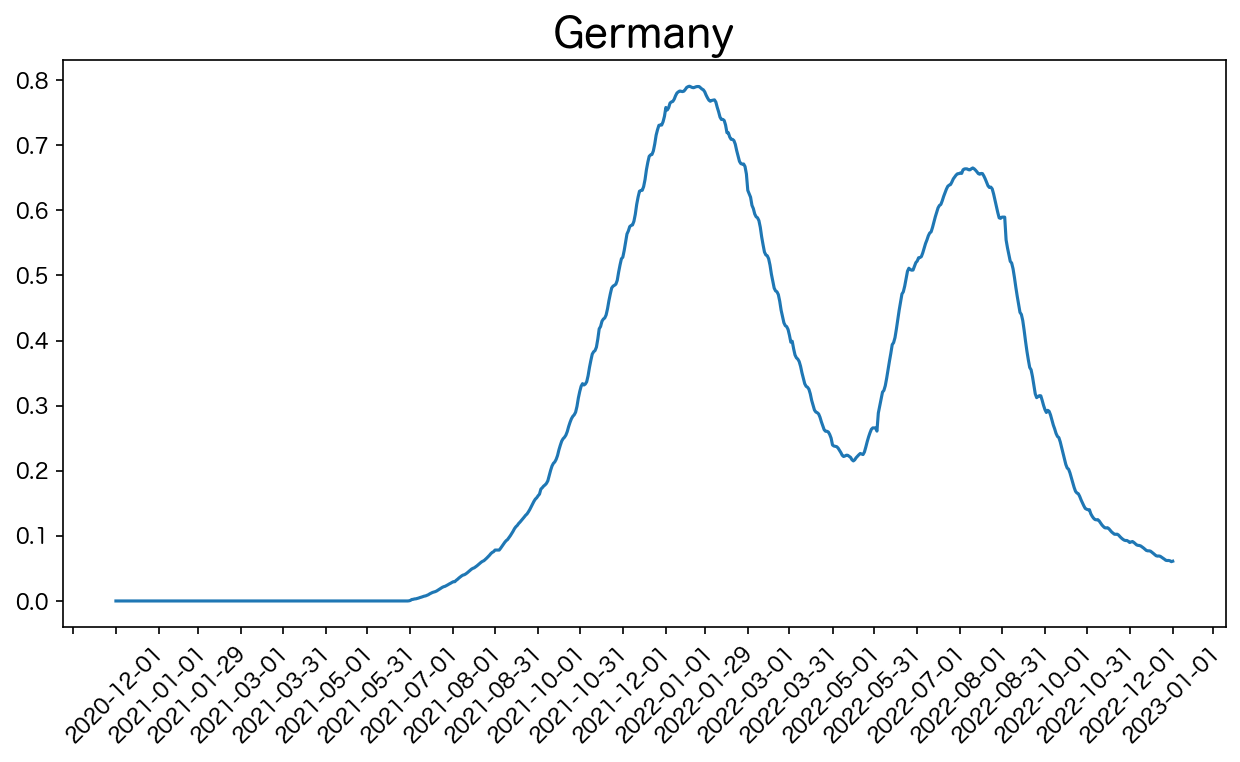

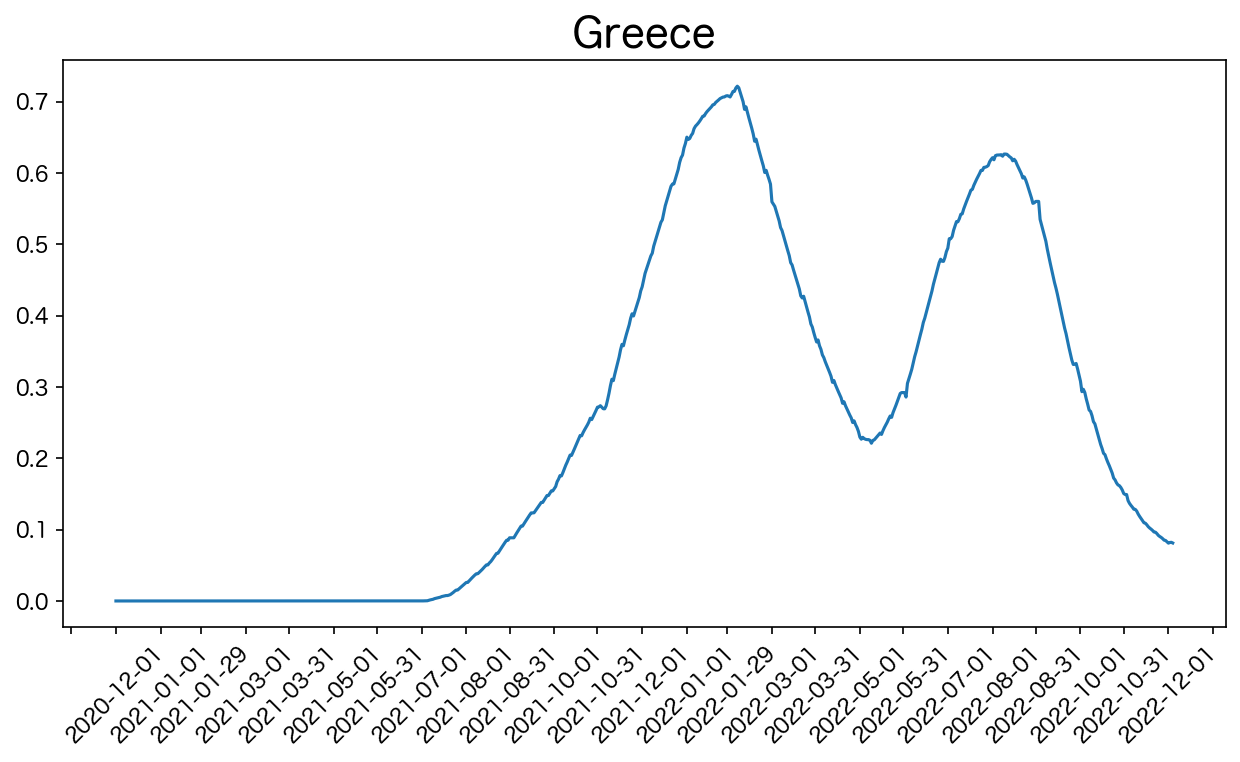

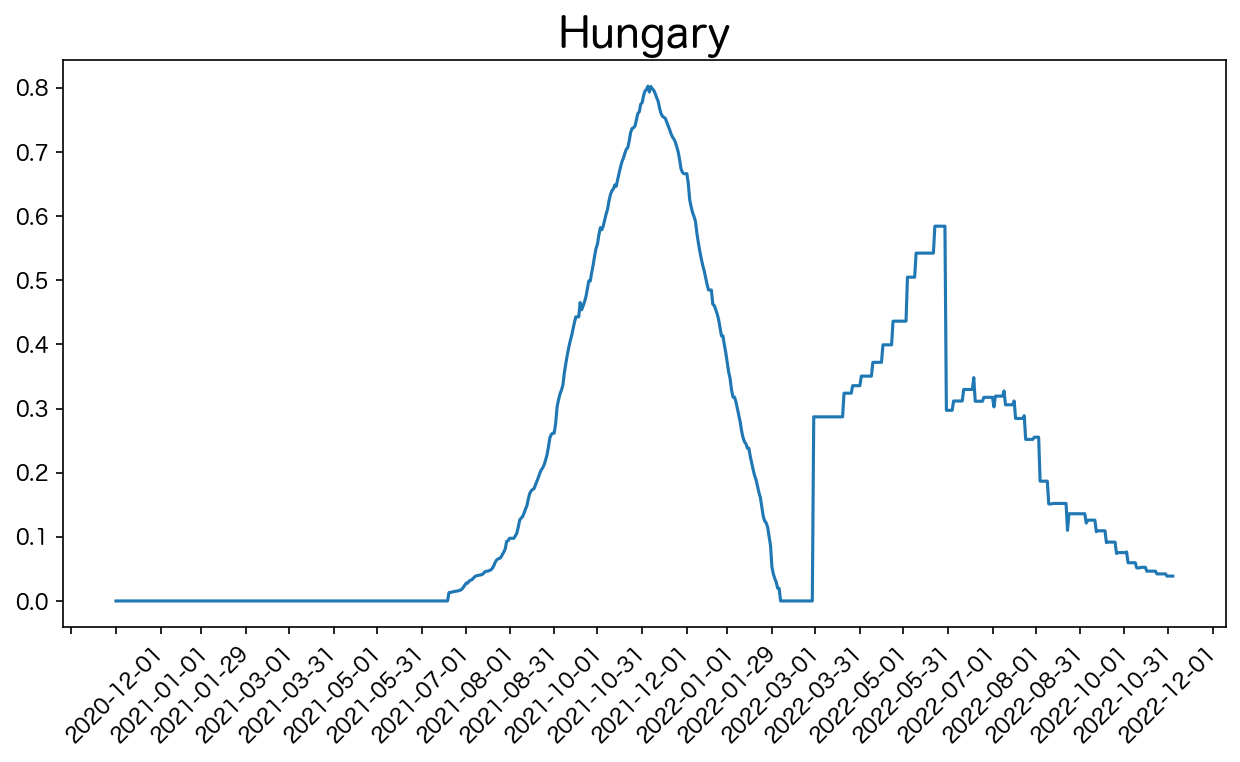

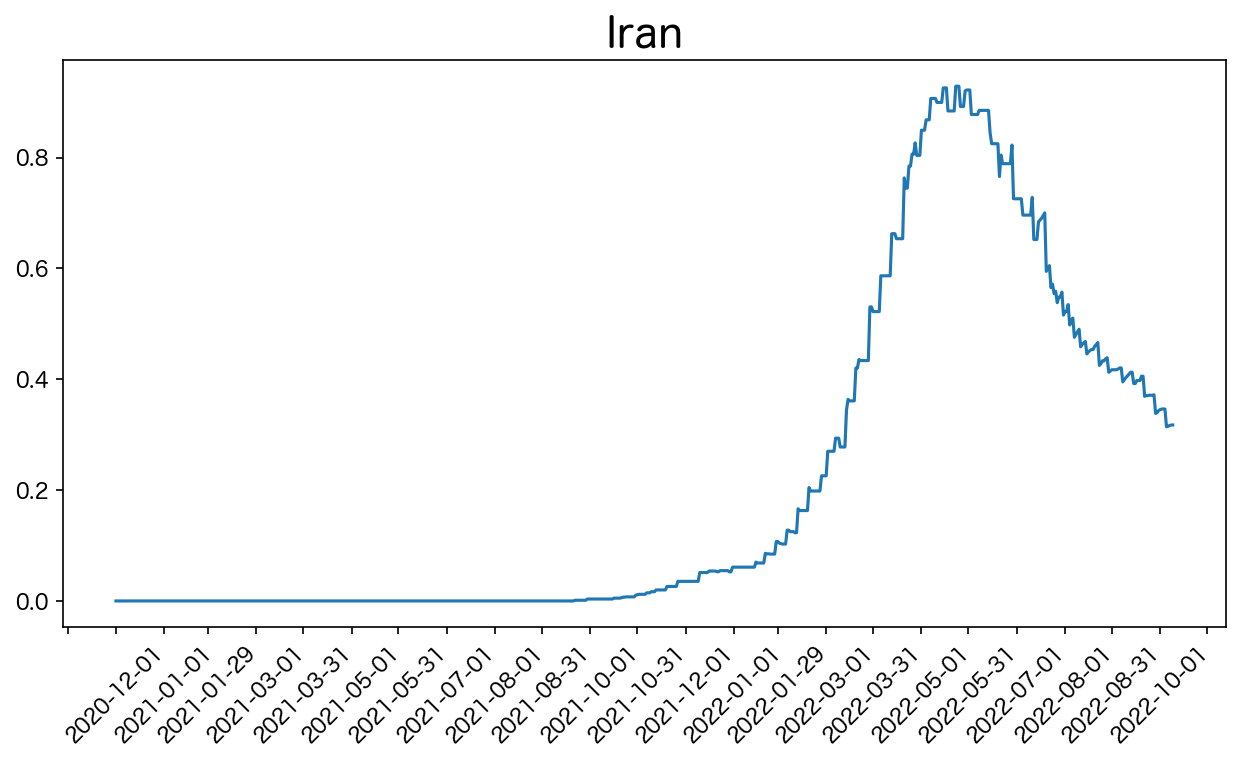

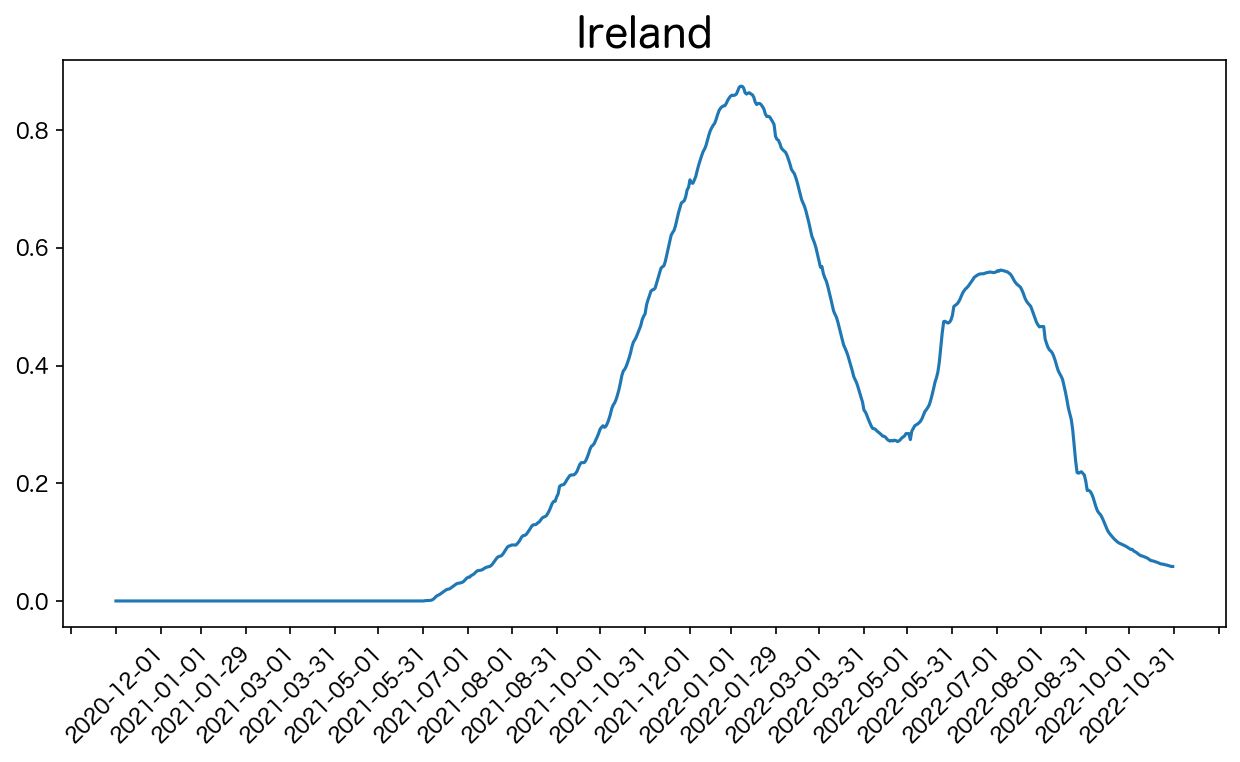

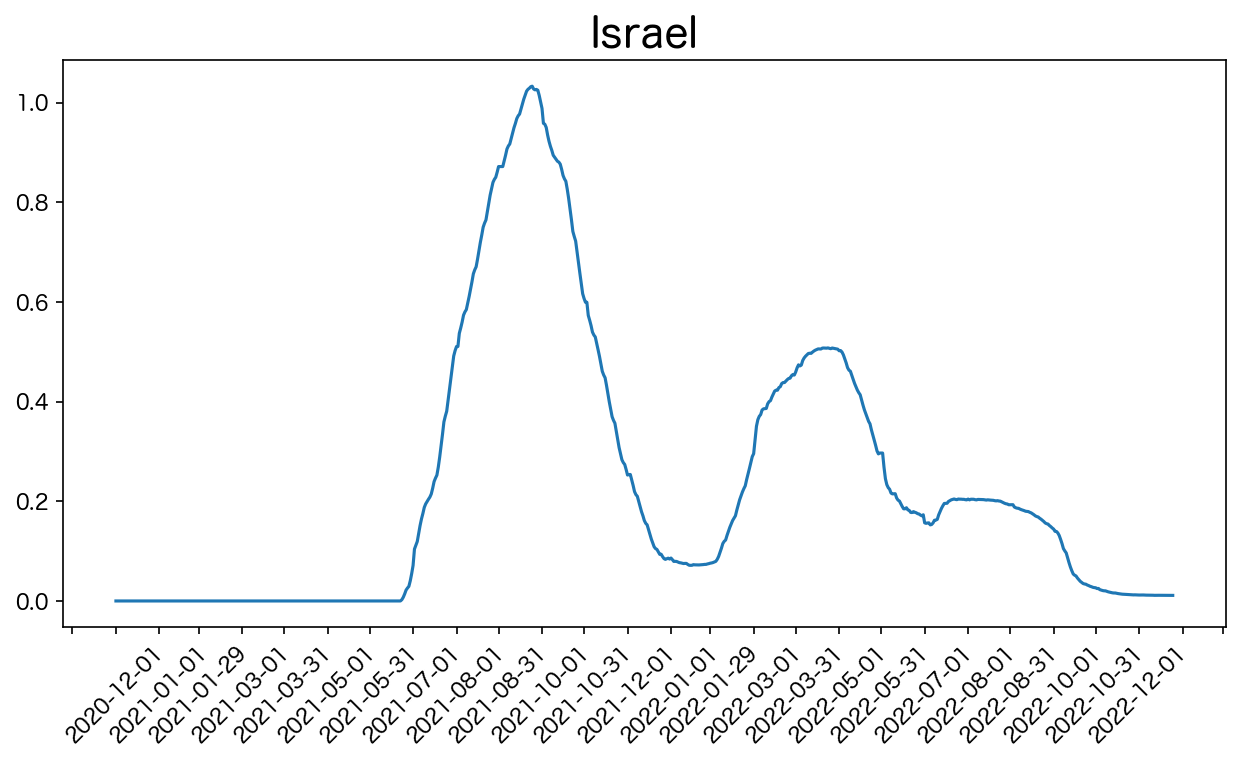

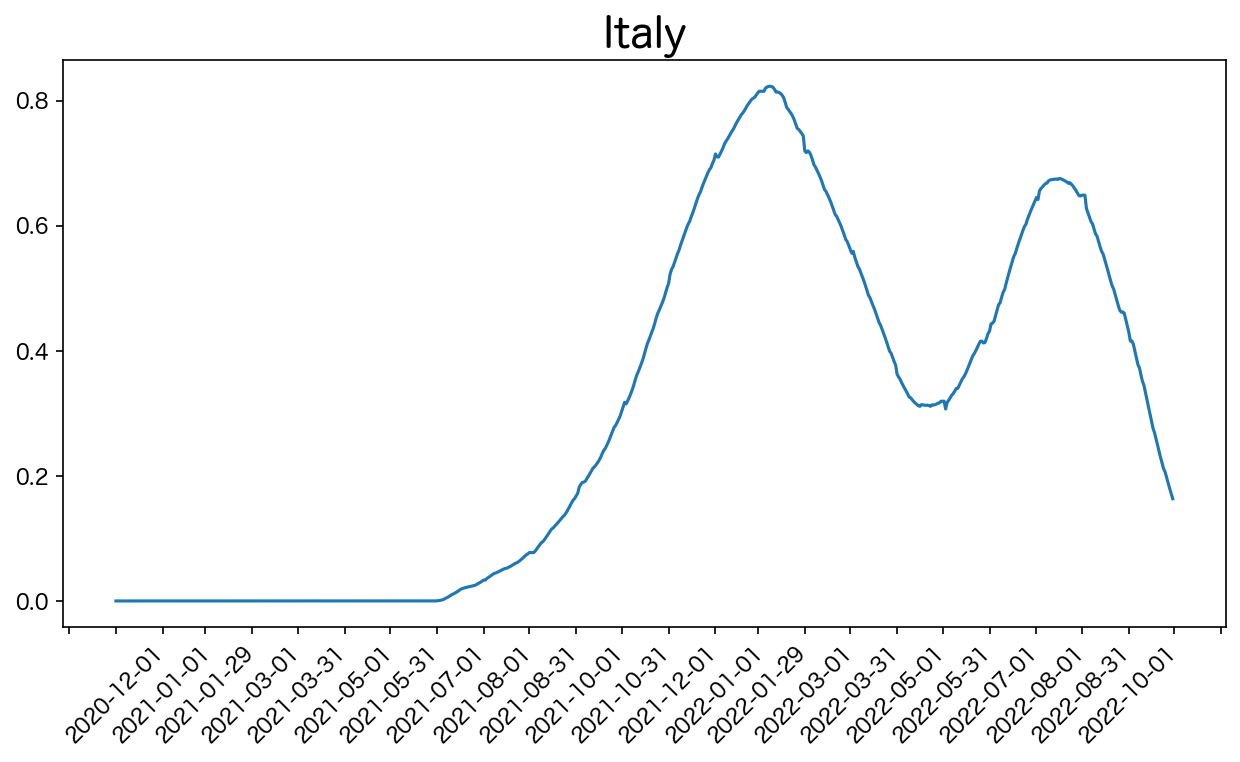

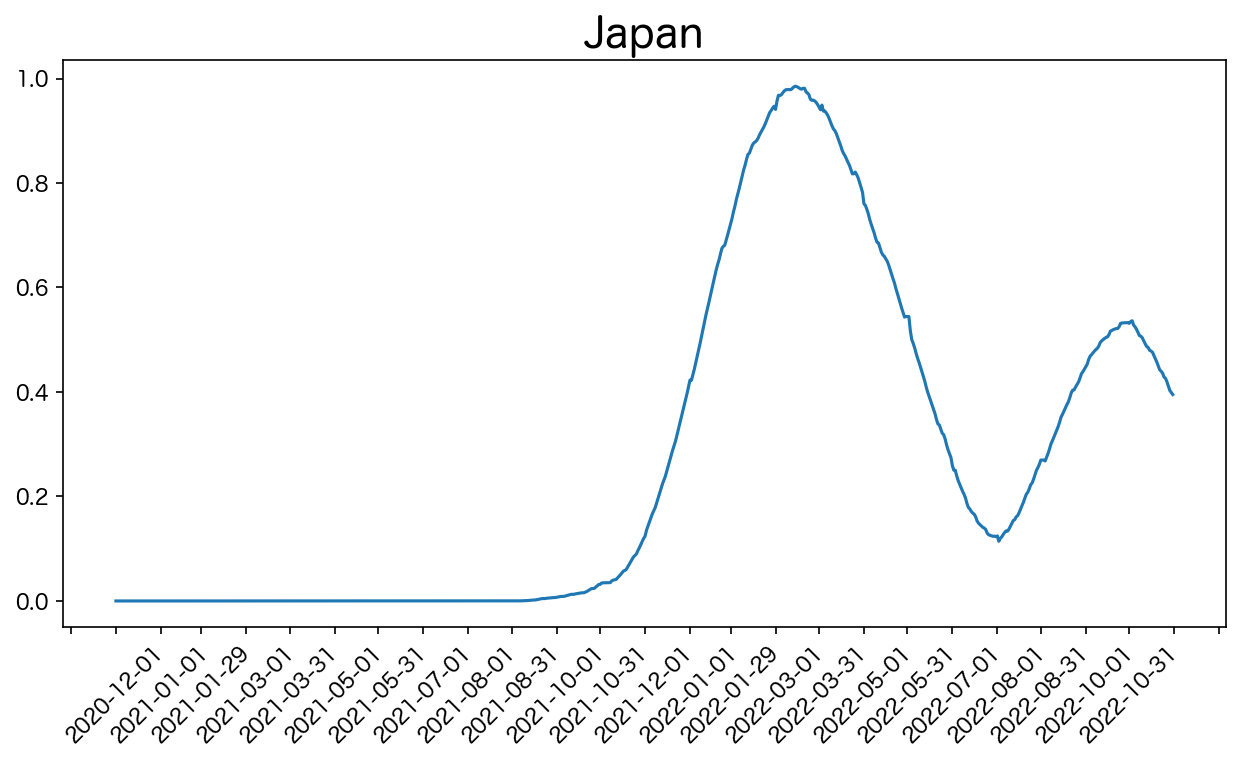

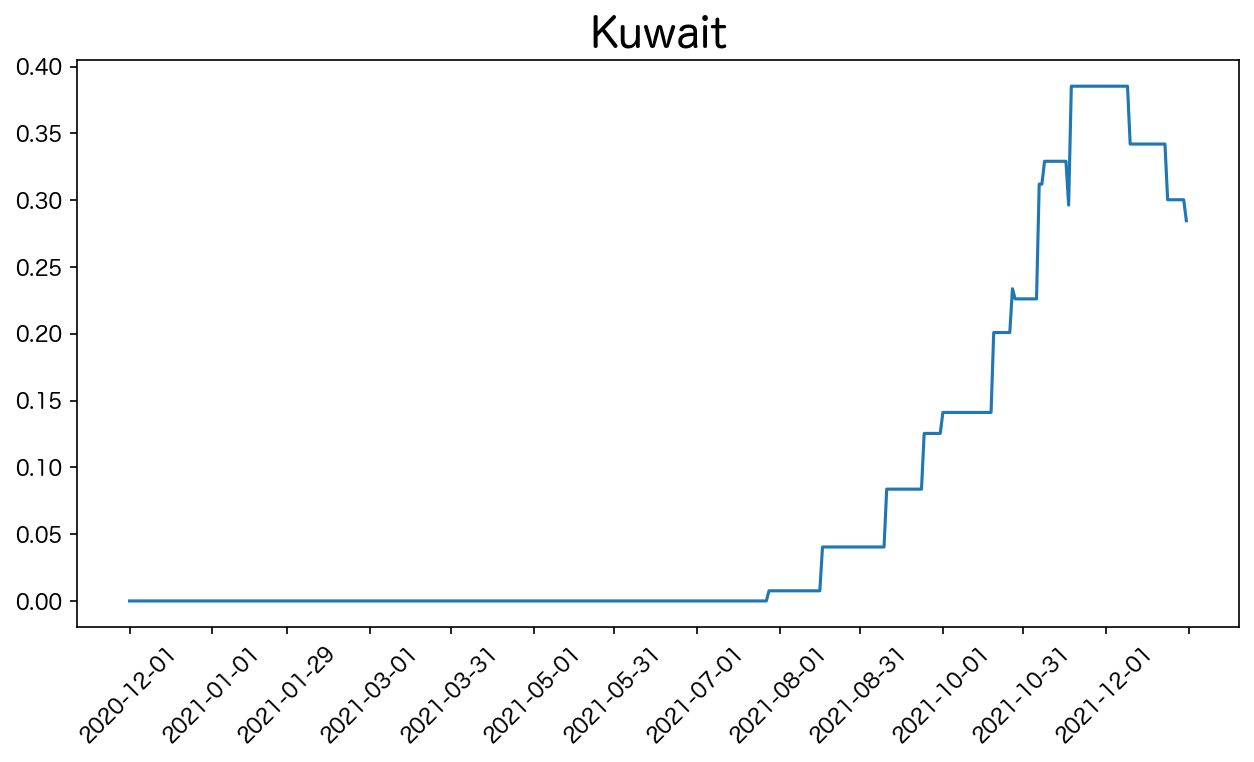

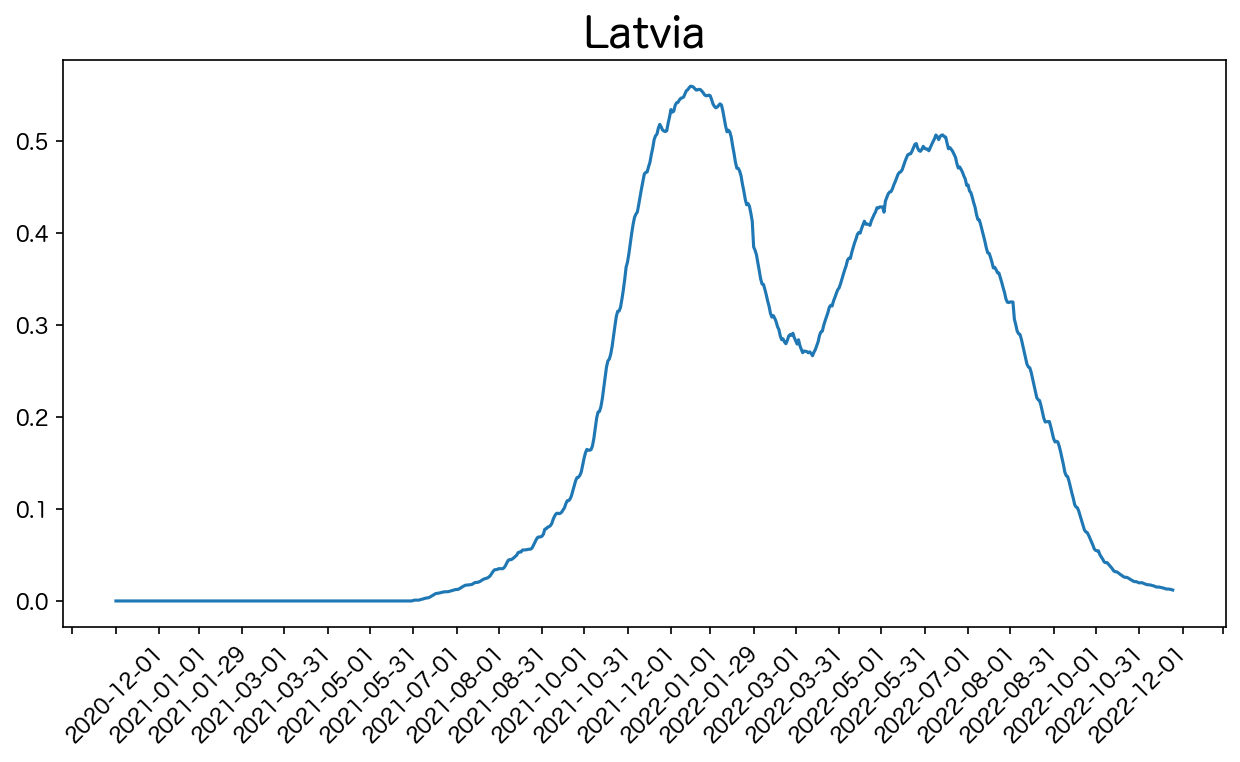

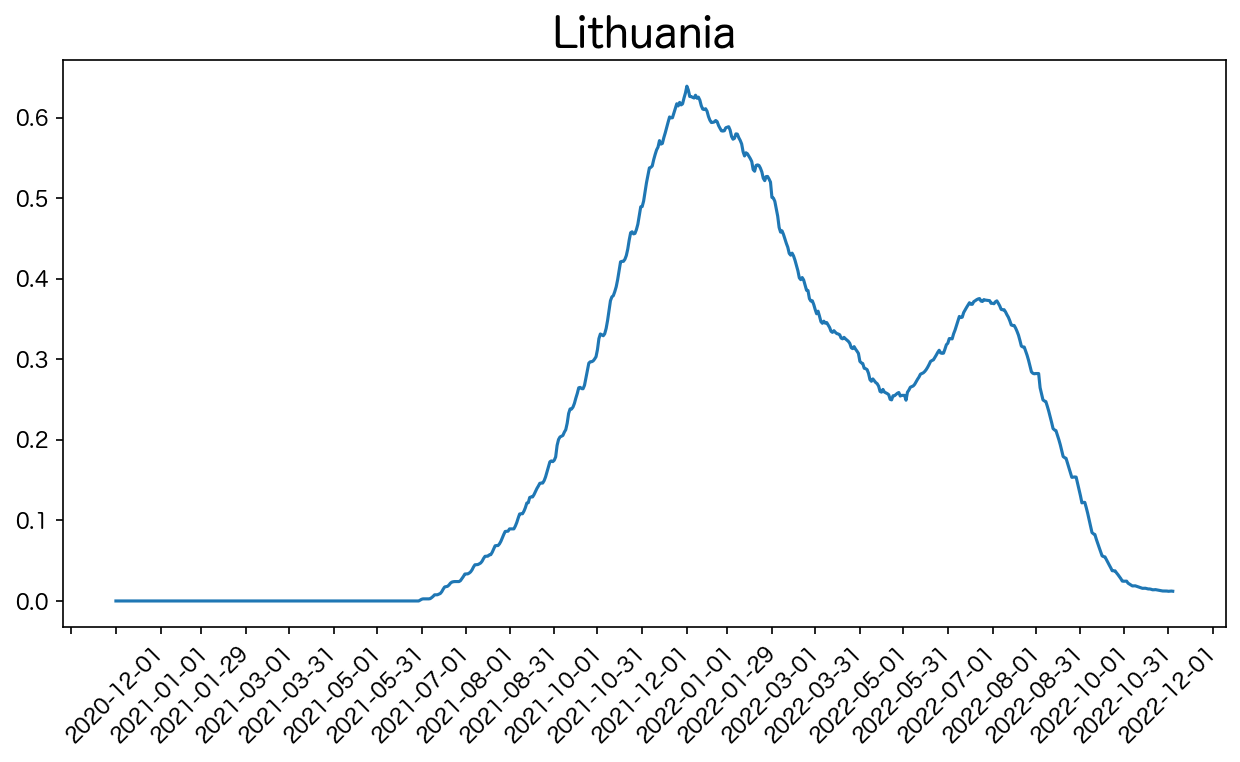

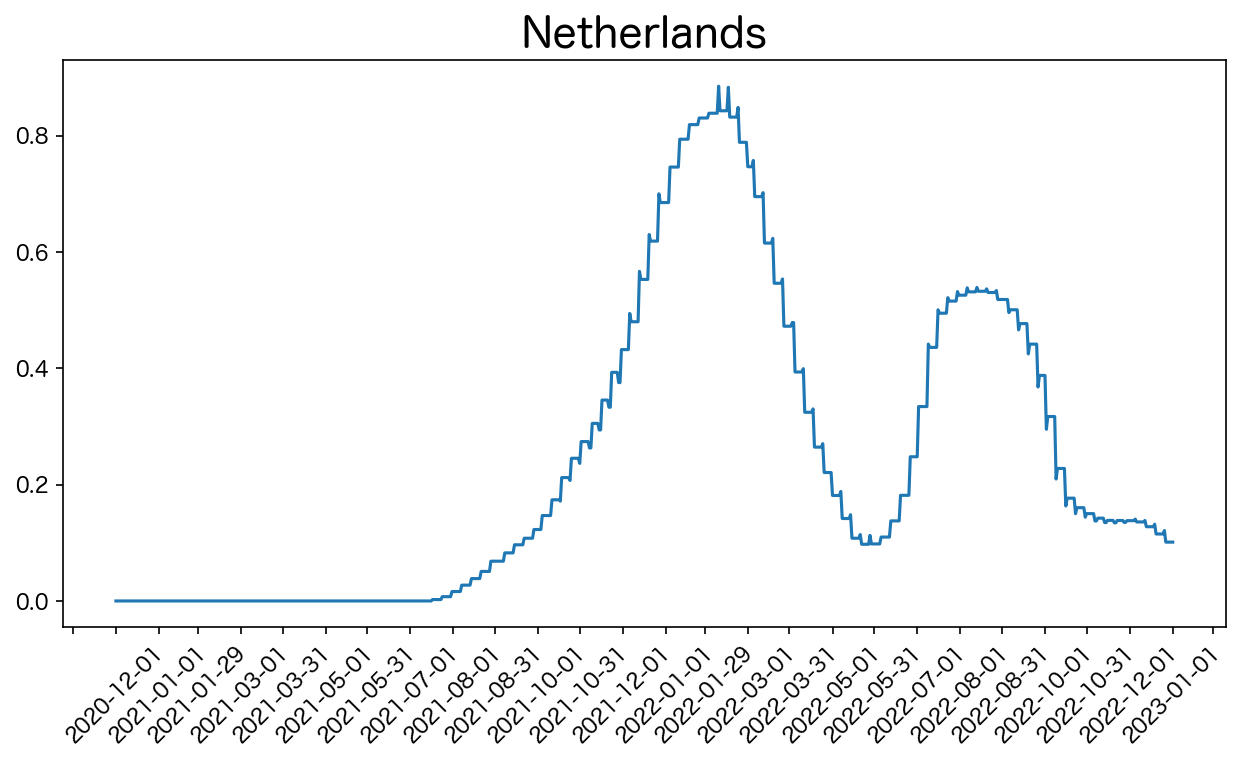

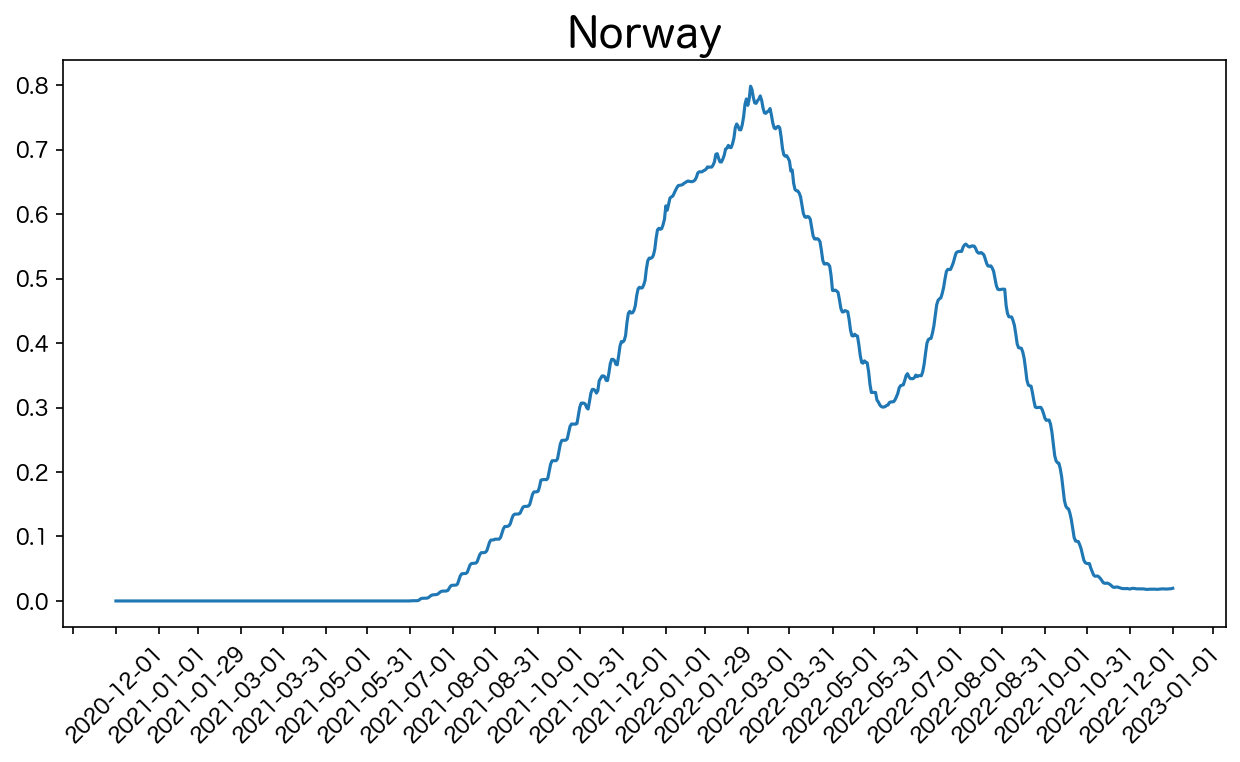

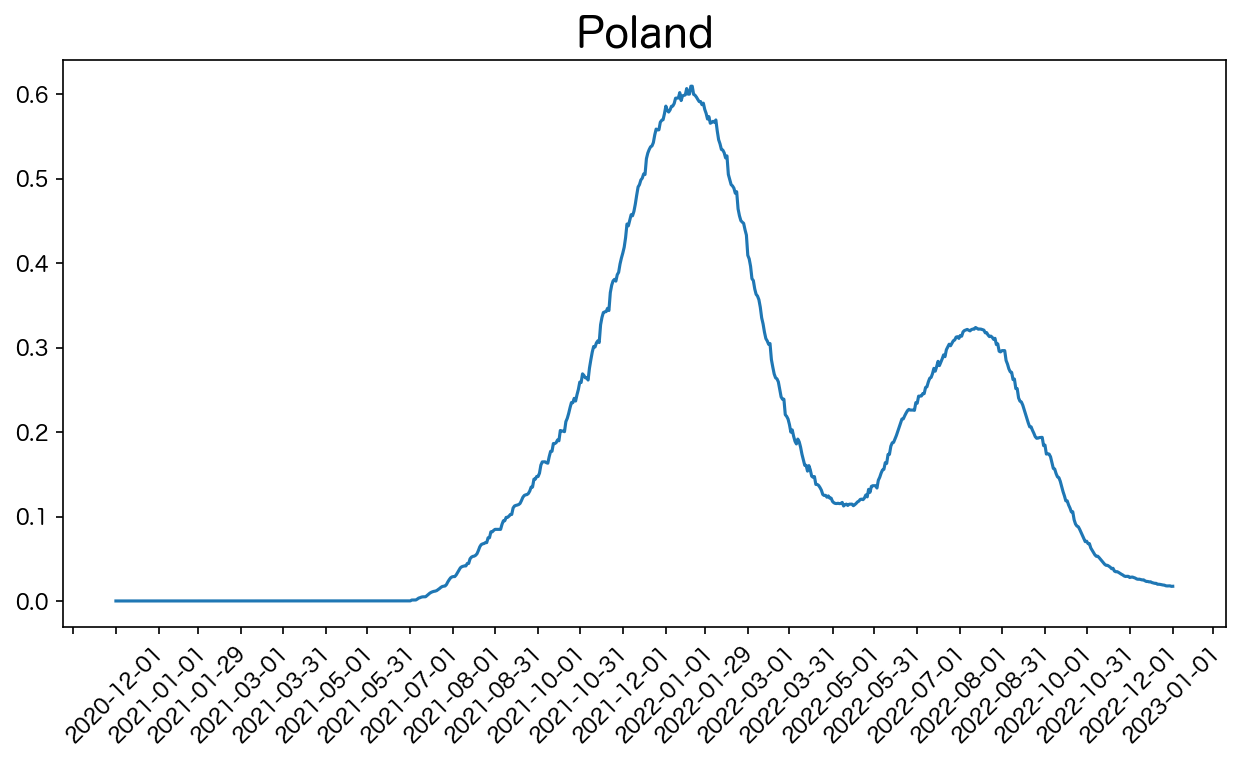

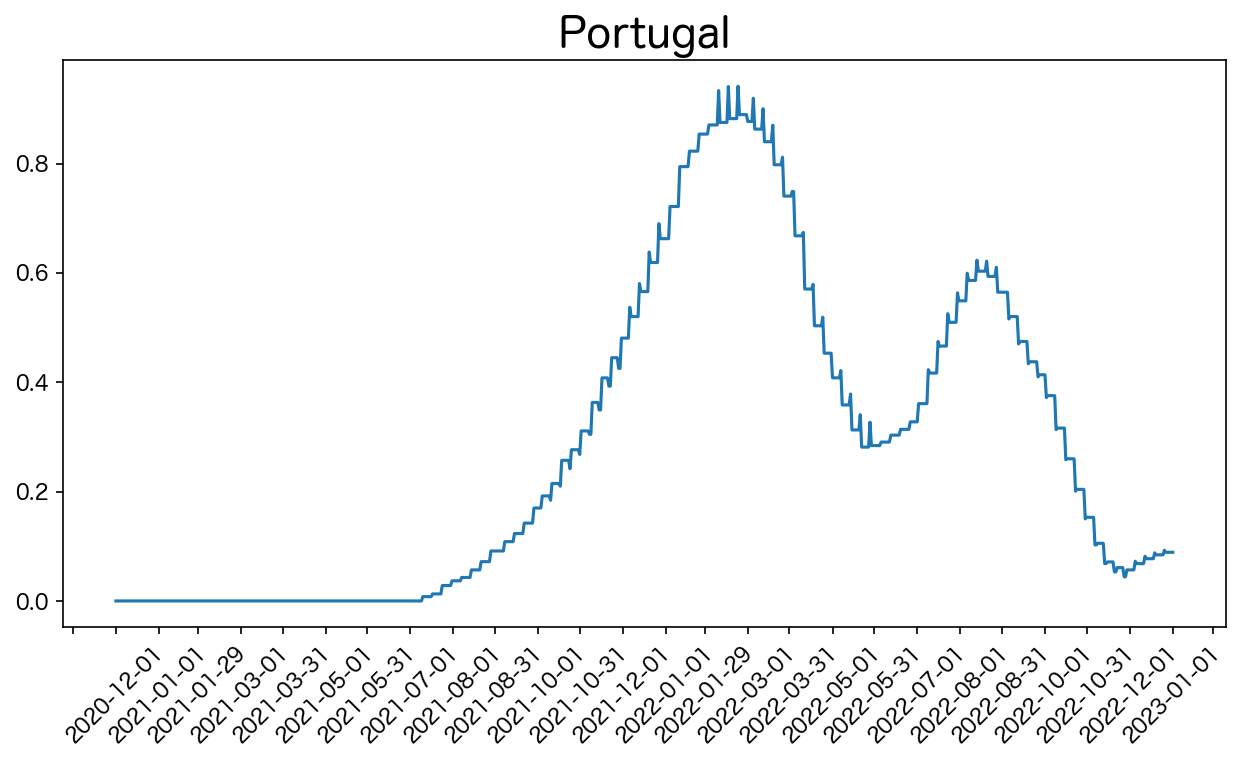

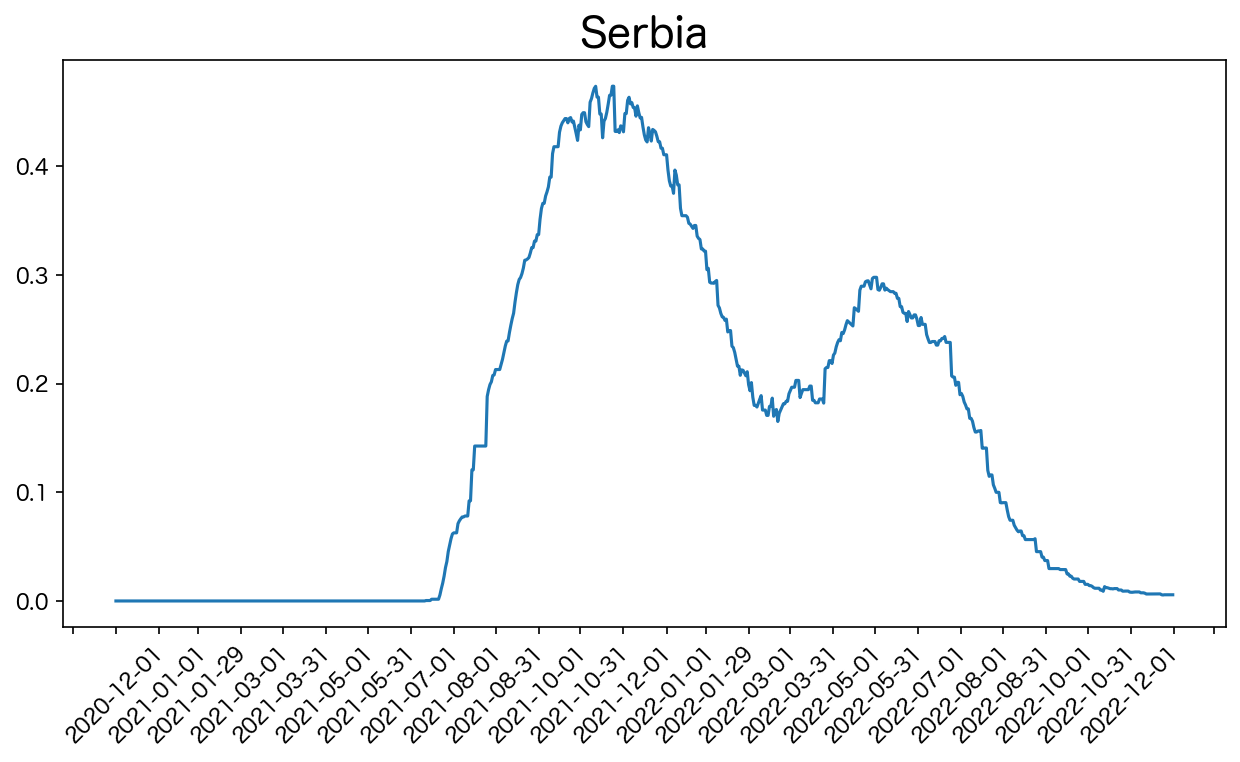

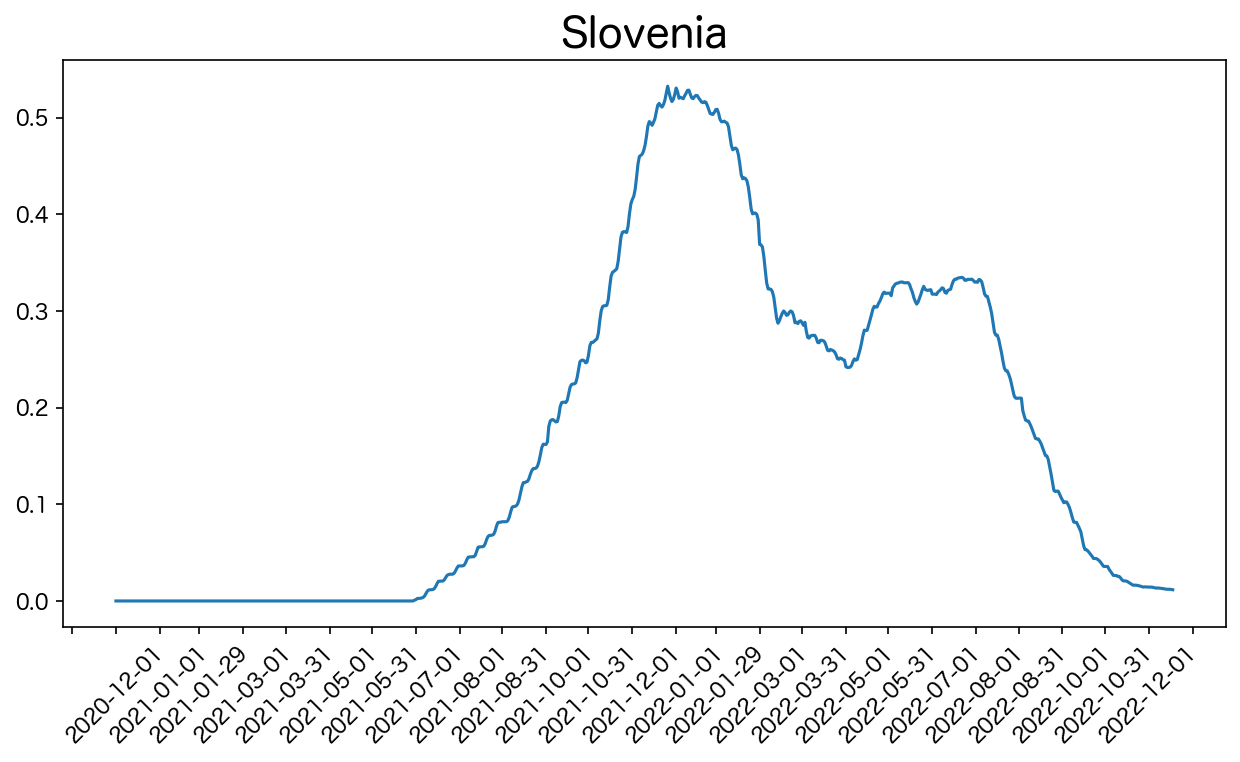

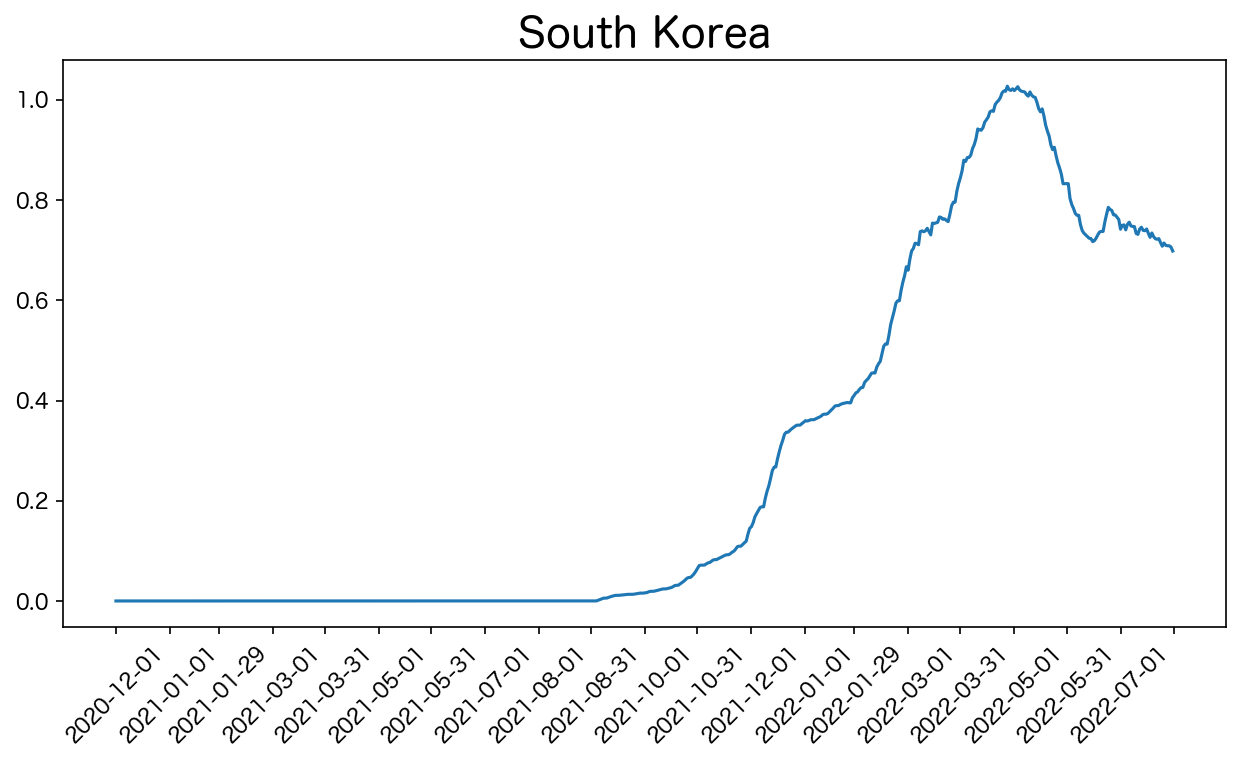

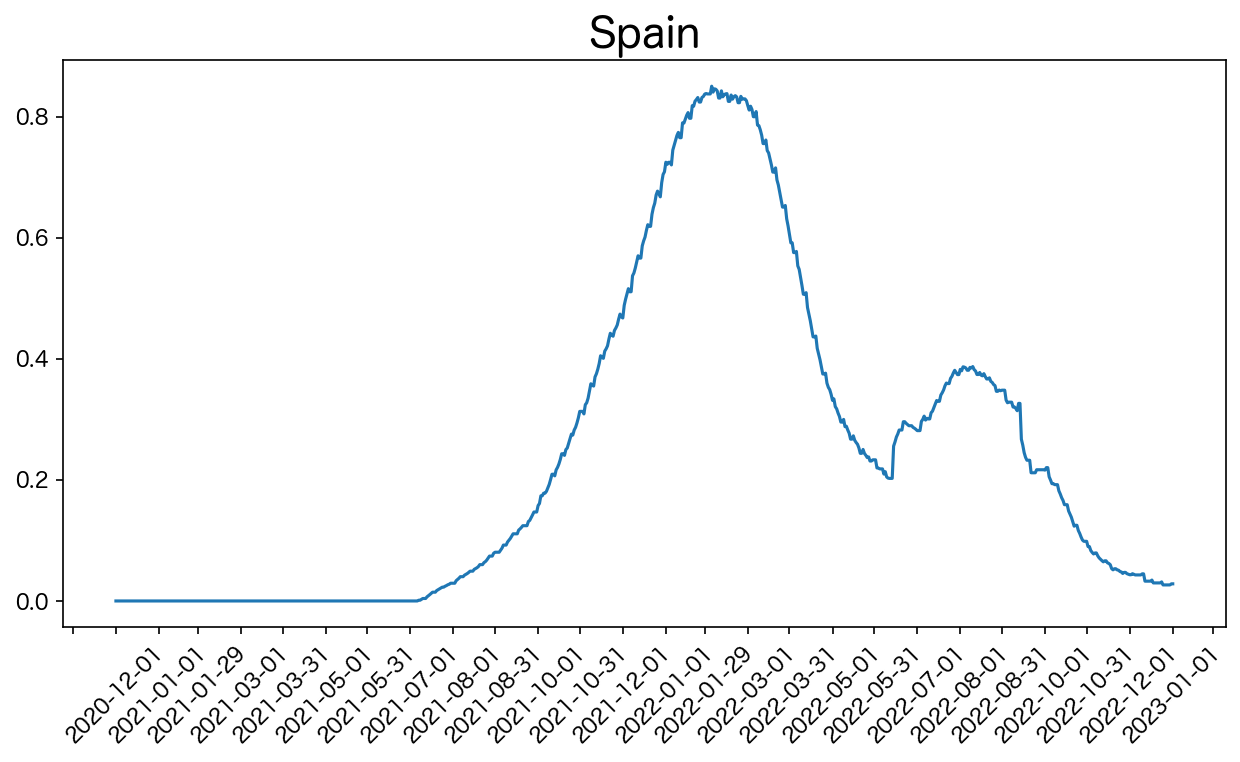

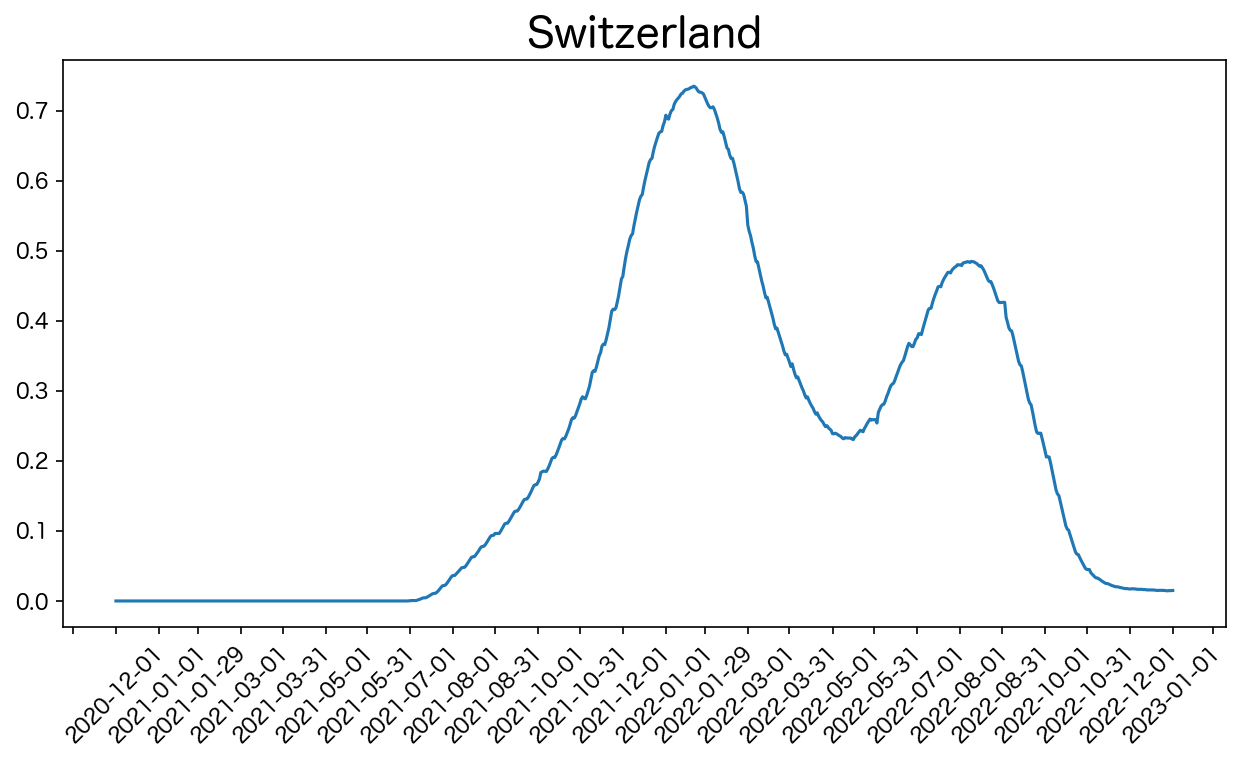

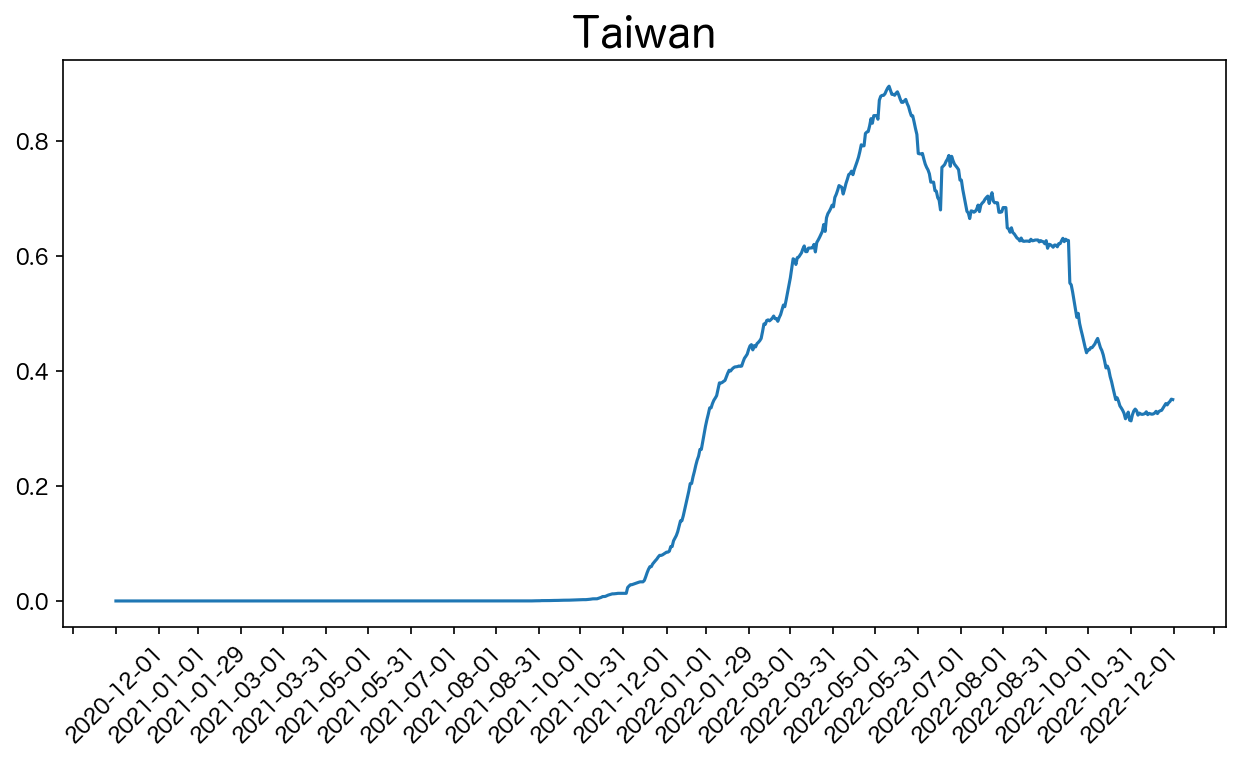

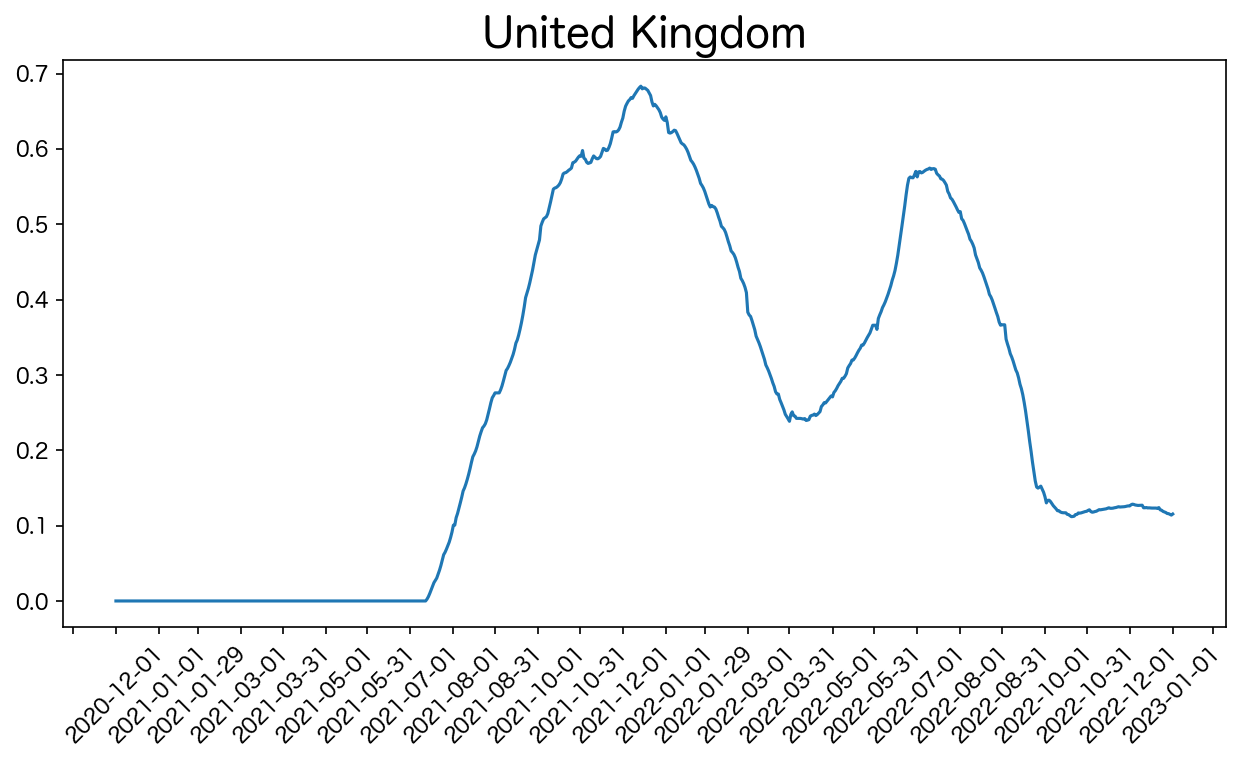

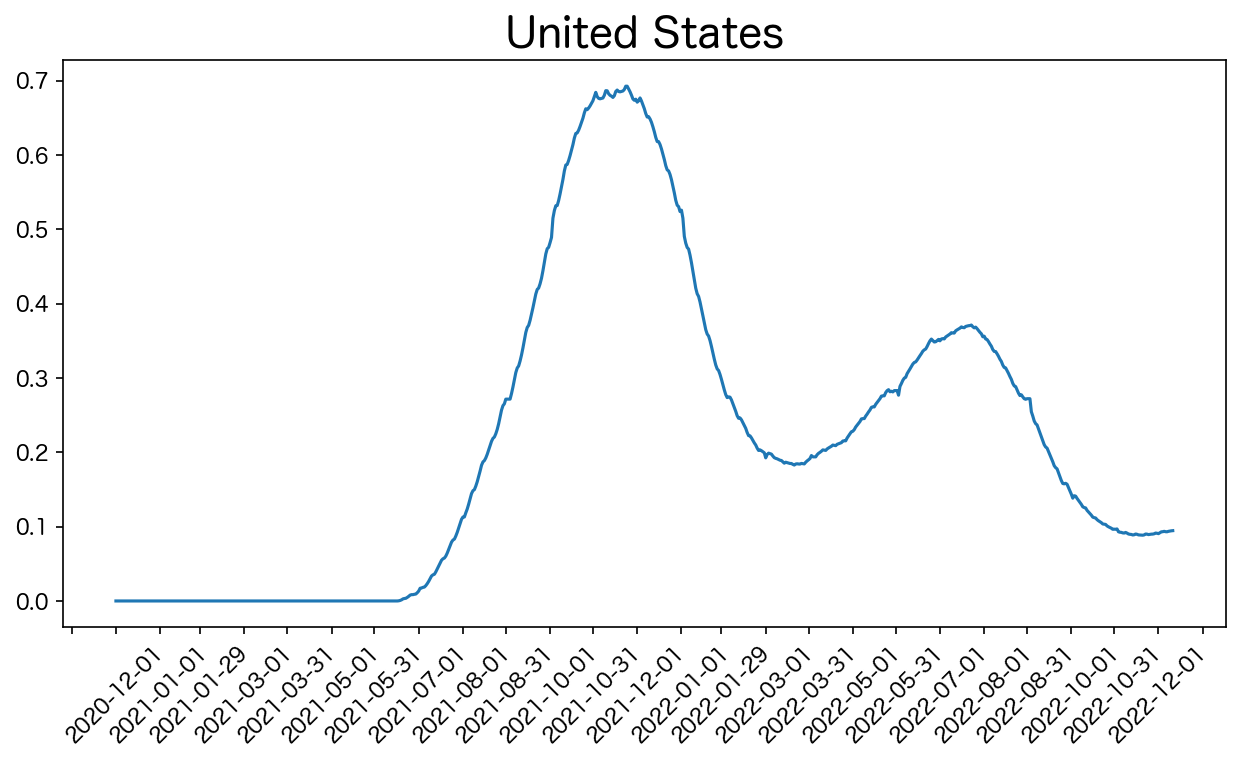

In [258]:
from matplotlib import pyplot as plt
#fmt
#plt.plot(tmp_df['date'].iloc[340:350],tmp_df['total_vaccinations_per_hundred'].iloc[340:350])
for Countryname in new_join_df.location.unique():
    tmp_df=new_join_df[new_join_df['location']==Countryname].reset_index(drop=True)
    for period in lst_dose_per[2:3]:
        #print(period)
        fig,ax = plt.subplots()
        fmt = mdates.MonthLocator(interval=1)
        plt.plot(tmp_df['date'],tmp_df[period])
        
        ax.xaxis.set_major_locator(fmt)
        ax.tick_params(axis='x', labelrotation=45)
        plt.title(Countryname,fontsize=20)
        fig.set_dpi(150)
        fig.set_size_inches(10,5)


## Extract TPARD

In [249]:
freq = 3 

# creating labels of catetorical classes
range_end = 21 
lst_overall=create_overall_period_lst(freq,range_end)

use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_overall #lst_1dose + lst_2dose + lst_3dose
new_df_overall = pd.DataFrame(columns=use_lst)
start_date_ref = '2021-01-01'

start_date_data = '2020-12-01'
end_date = '2023-03-31'

new_df_overall = feature_extraction_overall(df,use_Country_lst,use_lst,start_date_data,start_date_ref, end_date, freq) # 62 countries

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_53101/609786767.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period


****skipping Andorra data for lack of new_deaths_smoothed.
****skipping Argentina data for lack of excess_mortality.
****skipping Bahrain data for lack of excess_mortality.
****skipping Bangladesh data for lack of excess_mortality.
****skipping Belarus data for lack of excess_mortality.
****skipping Bhutan data for lack of excess_mortality.
****skipping Cambodia data for lack of excess_mortality.
****skipping Cayman Islands data for lack of excess_mortality.
****skipping China data for lack of excess_mortality.
****skipping Cook Islands data for lack of excess_mortality.
****skipping El Salvador data for lack of excess_mortality.
****skipping England data for lack of excess_mortality.
****skipping Faeroe Islands data for lack of new_deaths_smoothed.
****skipping Gibraltar data for lack of excess_mortality.
****skipping Guernsey data for lack of excess_mortality.
****skipping Honduras data for lack of excess_mortality.
****skipping Isle of Man data for lack of excess_mortality.
****skip

### merge with VA-TPAV

In [250]:
new_join_df = pd.merge(new_df, new_df_overall[['location','date']+lst_overall],  how='inner', on=['location','date']) #, right_on = ['B_c1','c2'])
new_join_df.location.unique()

array(['Australia', 'Austria', 'Azerbaijan', 'Belgium', 'Bermuda',
       'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Cuba',
       'Cyprus', 'Czechia', 'Denmark', 'Ecuador', 'Estonia', 'Finland',
       'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland',
       'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kuwait', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malaysia', 'Maldives',
       'Netherlands', 'New Zealand', 'Norway', 'Panama', 'Paraguay',
       'Peru', 'Poland', 'Portugal', 'Serbia', 'Singapore', 'Slovenia',
       'South Korea', 'Spain', 'Switzerland', 'Taiwan', 'Thailand',
       'United Kingdom', 'United States', 'Uruguay', 'Uzbekistan'],
      dtype=object)

## remove southern + equatorial countries

In [135]:
equatorial_countries=[ 'Brazil', 'Colombia', 'Costa Rica', 'Cuba','Ecuador','Malaysia','Maldives','Panama',
                      'Peru','Singapore','Thailand','Hong Kong'] #
south_countries=['Uruguay','New Zealand','Australia','Paraguay','Chile'] #  

In [251]:
new_join_df = new_join_df[~new_join_df['location'].isin(equatorial_countries+south_countries)].reset_index(drop=True)

In [252]:
rm_countries_lst = ['Iceland','Uzbekistan','Liechtenstein','Bermuda','Luxembourg'] 
new_join_df = new_join_df[~new_join_df['location'].isin(rm_countries_lst)].reset_index(drop=True)

In [253]:
north_countries = [s for s in new_df_overall.location.unique() if s not in equatorial_countries + south_countries]

### check # of countries using Weekly or Monthly update

In [247]:
tmp_lst = []
for Countryname in new_join_df.location.unique():
    per,cnt = np.unique(new_join_df[new_join_df['location']==Countryname]['excess_mortality'],return_counts=True)
    cnt_lst=list(set(cnt))
    tmp_lst.append((Countryname,cnt_lst))
print('Weekly : {}; Monthly : {}.'.format(len([x for x in tmp_lst if 7 in x[1]]),len([x for x in tmp_lst if 7 not in x[1]])))

Weekly : 27; Monthly : 6.


### Model running

In [142]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] 
#mdl_x_lst= ['new_deaths_smoothed_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.528179
re_est_ex_mortality_Norm                  0.528179                  1.000000
[LR_MDL] Self-Rmse for All is : 0.039699603177032576
Self-R2 is : 0.2789735432944782
Cross-validataion R2 : [0.19373505 0.04773657 0.26456752 0.32356993 0.34347282].
Cross-validataion R2 average : 0.23461638052916828.
Cross-validataion R2 std : 0.10700923052009455.
Cross-validataion mse : [0.04096185545470696, 0.0452501496918377, 0.04538264166277863, 0.041498921846187, 0.028773497707329163].
Cross-validataion mse average : 0.040373413272567896.
Cross-validataion mse std : 0.006083518752169738.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.279

### Use covid death + TPARDs + TPAVIs (no countriwise CV)

In [143]:
mdl_x_lst = lst_overall +lst_dose_per #lst_1dose+lst_2dose +lst_3dose # lst_dose_per #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          all_dose_1_3m  all_dose_4_6m  all_dose_7_9m  \
all_dose_1_3m                  1.000000       0.363561       0.041168   
all_dose_4_6m                  0.363561       1.000000       0.399383   
all_dose_7_9m                  0.041168       0.399383       1.000000   
all_dose_10_12m               -0.298470       0.124681       0.448091   
all_dose_13m+                 -0.464600      -0.284756       0.095309   
re_est_ex_mortality_Norm      -0.011825       0.121080       0.130580   

                          all_dose_10_12m  all_dose_13m+  \
all_dose_1_3m                   -0.298470      -0.464600   
all_dose_4_6m                    0.124681      -0.284756   
all_dose_7_9m                    0.448091       0.095309   
all_dose_10_12m                  1.000000       0.483648   
all_dose_13m+                    0.483648       1.000000   
re_est_ex_mortality_Norm         0.034097       0.051347   

                          re_est_

In [254]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall 
mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.528179
re_est_ex_mortality_Norm                  0.528179                  1.000000
[LR_MDL] Self-Rmse for All is : 0.03202073718887052
Self-R2 is : 0.418437545246119
Cross-validataion R2 : [0.28188829 0.28200228 0.3613743  0.45274499 0.49901761].
Cross-validataion R2 average : 0.37540549225921993.
Cross-validataion R2 std : 0.08823588270250107.
Cross-validataion mse : [0.036483278025142, 0.034118189798685354, 0.03940881325454054, 0.03357404440705684, 0.021956464525923012].
Cross-validataion mse average : 0.03310815800226955.
Cross-validataion mse std : 0.00594452981385561.
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.417
M

### VA-TPAV and COVID death

In [272]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_dose_per #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.108964   
all_dose_1_3m                            -0.108964       1.000000   
all_dose_4_6m                            -0.125590       0.363561   
all_dose_7_9m                             0.036662       0.041168   
all_dose_10_12m                          -0.109982      -0.298470   
all_dose_13m+                            -0.258879      -0.464600   
re_est_ex_mortality_Norm                  0.528179      -0.011825   

                          all_dose_4_6m  all_dose_7_9m  all_dose_10_12m  \
new_deaths_smoothed_Norm      -0.125590       0.036662        -0.109982   
all_dose_1_3m                  0.363561       0.041168        -0.298470   
all_dose_4_6m                  1.000000       0.399383         0.124681   
all_dose_7_9m                  0.399383       1.000000         0.448091   
all_dose_10_12m                0.12468

### VA-TPAV, TPARD, and COVID death

In [147]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall + lst_dose_per

mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.108964   
all_dose_1_3m                            -0.108964       1.000000   
all_dose_4_6m                            -0.125590       0.363561   
all_dose_7_9m                             0.036662       0.041168   
all_dose_10_12m                          -0.109982      -0.298470   
all_dose_13m+                            -0.258879      -0.464600   
re_est_ex_mortality_Norm                  0.528179      -0.011825   

                          all_dose_4_6m  all_dose_7_9m  all_dose_10_12m  \
new_deaths_smoothed_Norm      -0.125590       0.036662        -0.109982   
all_dose_1_3m                  0.363561       0.041168        -0.298470   
all_dose_4_6m                  1.000000       0.399383         0.124681   
all_dose_7_9m                  0.399383       1.000000         0.448091   
all_dose_10_12m                0.12468

### Added PFE

In [146]:
pfe_lst = ['last_year_new_deaths_smoothed_1_3m_Norm','last_year_new_deaths_smoothed_4_6m_Norm','last_year_new_deaths_smoothed_7_9m_Norm','last_year_new_deaths_smoothed_10_12m_Norm','last_year_new_deaths_smoothed_13_15m_Norm'] 

In [148]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_dose_per + pfe_lst[:1] ## lst_1dose + lst_2dose + lst_3dose 
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
all_dose_1_3m                                           -0.108964   
all_dose_4_6m                                           -0.125590   
all_dose_7_9m                                            0.036662   
all_dose_10_12m                                         -0.109982   
all_dose_13m+                                           -0.258879   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625706   
re_est_ex_mortality_Norm                                 0.528179   

                                         all_dose_1_3m  all_dose_4_6m  \
new_deaths_smoothed_Norm                     -0.108964      -0.125590   
all_dose_1_3m                                 1.000000       0.363561   
all_dose_4_6m                                 0.363561       1.000000   
all_dose_7_9m                                 0.0411

In [150]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] +lst_overall + pfe_lst[:1] #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625706   
re_est_ex_mortality_Norm                                 0.528179   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.625706   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.115562   

                                         re_est_ex_mortality_Norm  
new_deaths_smoothed_Norm                                 0.528179  
last_year_new_deaths_smoothed_1_3m_Norm                  0.115562  
re_est_ex_mortality_Norm                                 1.000000  
[LR_MDL] Self-Rmse for All is : 0.030877158543386043
Self-R2 is : 0.439207285816

In [275]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] +lst_overall + lst_dose_per + pfe_lst[:1] #lst_1dose+lst_2dose +lst_3dose #
#mdl_x_lst= ['new_deaths_smoothed_30d_Norm']+ lst_overall + lst_1dose+lst_2dose +lst_3dose


mdl_y_lst = ['re_est_ex_mortality_Norm']

print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
all_dose_1_3m                                           -0.108964   
all_dose_4_6m                                           -0.125590   
all_dose_7_9m                                            0.036662   
all_dose_10_12m                                         -0.109982   
all_dose_13m+                                           -0.258879   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625706   
re_est_ex_mortality_Norm                                 0.528179   

                                         all_dose_1_3m  all_dose_4_6m  \
new_deaths_smoothed_Norm                     -0.108964      -0.125590   
all_dose_1_3m                                 1.000000       0.363561   
all_dose_4_6m                                 0.363561       1.000000   
all_dose_7_9m                                 0.0411

In [152]:
res_df

,params,linear_weights,p_value
0,new_deaths_smoothed_Norm,0.781772,0.0
1,overall_1_3m,-0.150939,0.0
2,overall_4_6m,-0.097095,0.0
3,overall_7_9m,-0.140961,0.0
4,overall_10_12m,-0.234072,0.0
5,overall_13_15m,-0.537697,0.0
6,overall_16_18m,-0.512566,0.0
7,overall_19_21m,-0.559136,0.0
8,overall_22m+,-0.598839,0.0
9,all_dose_1_3m,0.135470,0.0


### plot coefficients

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_53101/1429210982.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x +[''])
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_53101/1429210982.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + x +[''])


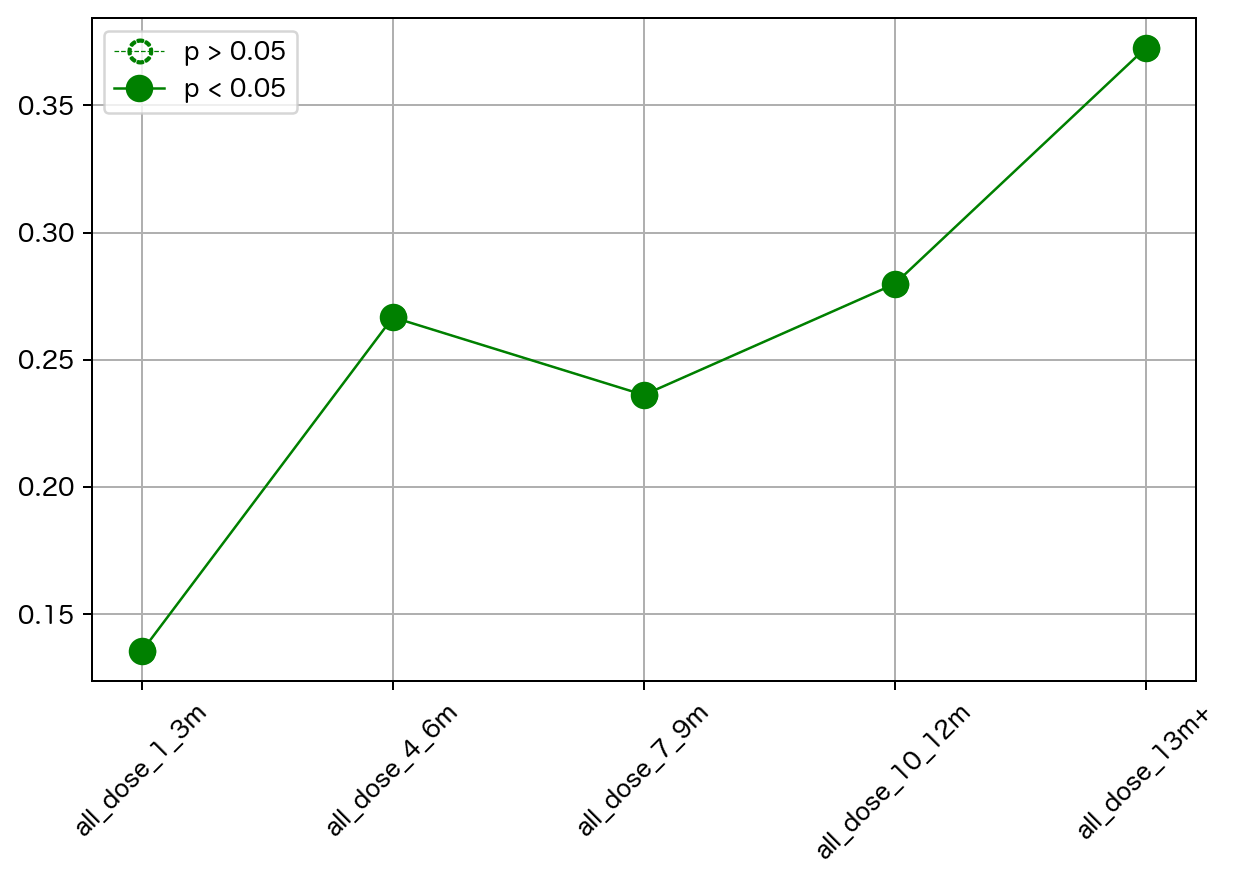

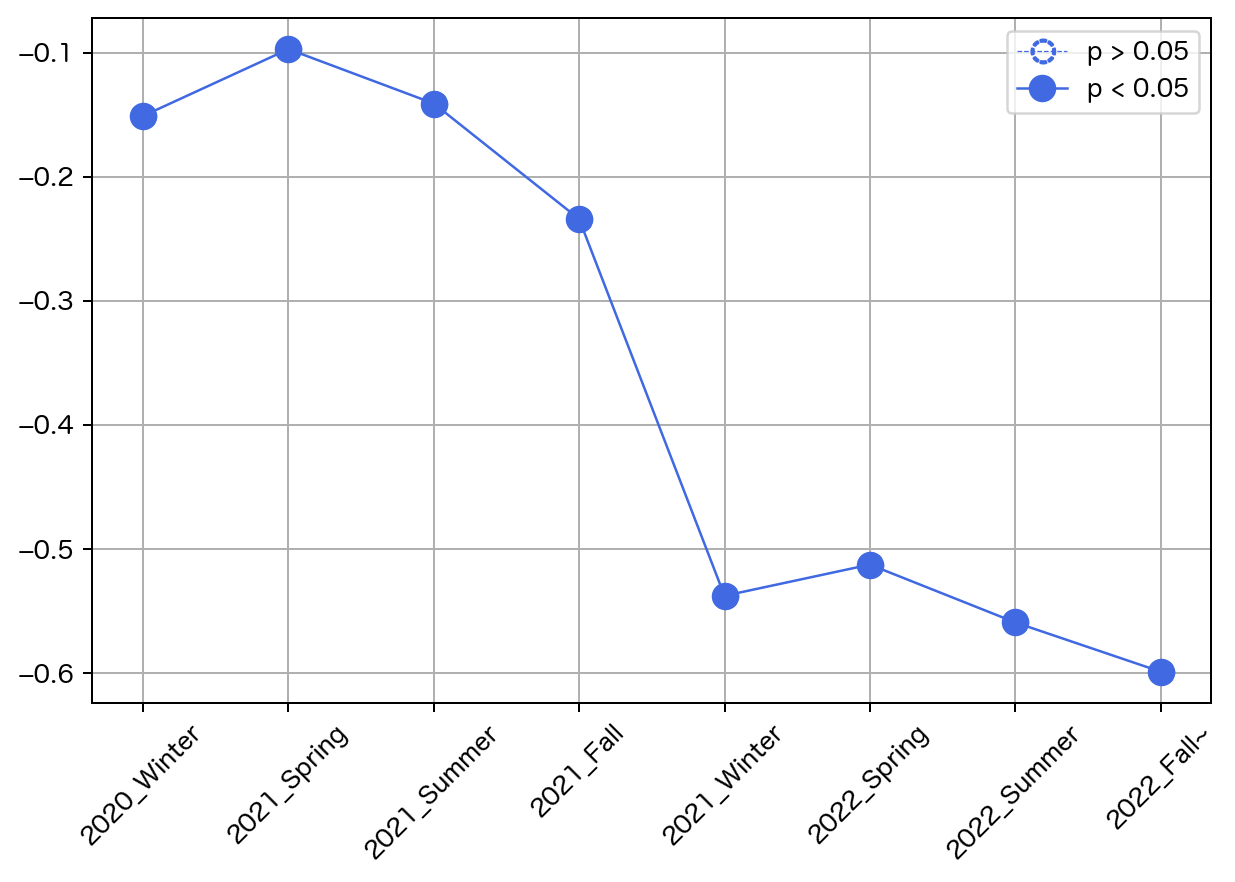

In [276]:
res_df['p005_linear_weights']=res_df['linear_weights']
res_df.loc[res_df['p_value'] > 0.05, 'p005_linear_weights'] = np.NAN
save_path = 'results_north'
os.makedirs(save_path,exist_ok=True)

#
outfile = '/'.join([save_path,'sum_all_dose_coefs.png'])
x_lst = res_df['params'].iloc[9:14].tolist()
y_dot_lst = res_df['linear_weights'].iloc[9:14].tolist()
y_solid_lst = res_df['p005_linear_weights'].iloc[9:14]

plt_curve_by_pvalue(x_lst,y_dot_lst,y_solid_lst,outfile,color='green')

#
outfile = '/'.join([save_path,'sum_all_dose_overall_coefs.png'])
season_data_lst = ['2020_Winter',
'2021_Spring',
'2021_Summer',
'2021_Fall',
'2021_Winter',
'2022_Spring',
'2022_Summer',
'2022_Fall~']
y_dot_lst = res_df['linear_weights'].iloc[1:9].tolist()
y_solid_lst = res_df['p005_linear_weights'].iloc[1:9]

plt_curve_by_pvalue(season_data_lst,y_dot_lst,y_solid_lst,outfile)



# Comparison between excess mortality caused by COVID death and TPAVIs

In [177]:
mdl_x_lst

['new_deaths_smoothed_Norm',
 'overall_1_3m',
 'overall_4_6m',
 'overall_7_9m',
 'overall_10_12m',
 'overall_13_15m',
 'overall_16_18m',
 'overall_19_21m',
 'overall_22m+',
 'all_dose_1_3m',
 'all_dose_4_6m',
 'all_dose_7_9m',
 'all_dose_10_12m',
 'all_dose_13m+',
 'last_year_new_deaths_smoothed_1_3m_Norm']

In [277]:
lst1=[]
lst2=[]
s_e=(9,14)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax(new_join_df,lr_mdl,Countryname,mdl_x_lst,s_e,'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nVA-TPAVs : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.16722147748627023
VA-TPAVs : 0.679818564567789



In [190]:
print('[Vax ex-mortality]')
for x,y in zip(new_join_df['location'].unique(),lst2):
    print('{} : {}'.format(x,y))

[Vax ex-mortality]
Austria : 0.7886824667982532
Azerbaijan : 0.46000239574255536
Belgium : 0.8022372429568924
Canada : 0.7336827478889132
Cyprus : 0.6846448563237634
Czechia : 0.5984564856575085
Denmark : 0.8100147670666593
Estonia : 0.5544999865907769
Finland : 0.7826521327193022
France : 0.7749630915130032
Germany : 0.7998714247875571
Greece : 0.6990224346740941
Hungary : 0.5719611572200312
Iran : 0.5263181710428289
Ireland : 0.7646297254052227
Israel : 0.7060275727250391
Italy : 0.795598645250547
Japan : 0.8779604488711337
Kuwait : 0.29093139619933855
Latvia : 0.5596893775552665
Lithuania : 0.5774844908105792
Netherlands : 0.7114671242817026
Norway : 0.7849546891714905
Poland : 0.5089953150657808
Portugal : 0.9001964750332022
Serbia : 0.45693695624153174
Slovenia : 0.5073952583832938
South Korea : 0.6793955759701673
Spain : 0.7482413223993829
Switzerland : 0.6702623545520542
Taiwan : 0.8525161200386864
United Kingdom : 0.7882446226421587
United States : 0.6660757991583204


In [192]:
lst1=[]
lst2=[]
s_e=(1,9)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax(new_join_df,lr_mdl,Countryname,mdl_x_lst,s_e,'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nTPARDs : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.16722147748627023
TPARDs : -0.5853794994269084



In [193]:
print('[TPARDs ex-mortality]')
for x,y in zip(new_join_df['location'].unique(),lst2):
    print('{} : {}'.format(x,y))

[TPARDs ex-mortality]
Austria : -0.5988393386852047
Azerbaijan : -0.5988393386852047
Belgium : -0.5988393386852047
Canada : -0.5591357863281028
Cyprus : -0.5988393386852047
Czechia : -0.5988393386852047
Denmark : -0.5988393386852047
Estonia : -0.5988393386852047
Finland : -0.5988393386852047
France : -0.5988393386852047
Germany : -0.5988393386852047
Greece : -0.5988393386852047
Hungary : -0.5988393386852047
Iran : -0.5988393386852047
Ireland : -0.5988393386852047
Israel : -0.5988393386852047
Italy : -0.5988393386852047
Japan : -0.5988393386852047
Kuwait : -0.23407174787562662
Latvia : -0.5988393386852047
Lithuania : -0.5988393386852047
Netherlands : -0.5988393386852047
Norway : -0.5988393386852047
Poland : -0.5988393386852047
Portugal : -0.5988393386852047
Serbia : -0.5988393386852047
Slovenia : -0.5988393386852047
South Korea : -0.5591357863281028
Spain : -0.5988393386852047
Switzerland : -0.5988393386852047
Taiwan : -0.5988393386852047
United Kingdom : -0.5988393386852047
United Stat

In [194]:
lst1=[]
lst2=[]
s_e=(14,15)
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax(new_join_df,lr_mdl,Countryname,mdl_x_lst,s_e,'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nPFE : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.16722147748627023
PFE : -0.024887030568631216



In [195]:
print('[PFE ex-mortality]')
for x,y in zip(new_join_df['location'].unique(),lst2):
    print('{} : {}'.format(x,y))

[PFE ex-mortality]
Austria : -0.014560435391301271
Azerbaijan : -0.010467898280037542
Belgium : -0.011557016222366403
Canada : -0.0484441374929946
Cyprus : -0.025535388960764818
Czechia : -0.012139614026185323
Denmark : -0.0349525820534884
Estonia : -0.030620299115650753
Finland : -0.10573322062829109
France : -0.031461247546381195
Germany : -0.03351723260394847
Greece : -0.04274757004737363
Hungary : -0.009861555262517814
Iran : -0.012439054394837395
Ireland : -0.015460446373796594
Israel : -0.010872532015325459
Italy : -0.02555165032561079
Japan : -0.08904482948328894
Kuwait : -0.0032799872341868967
Latvia : -0.010662113145426807
Lithuania : -0.008817941208977397
Netherlands : -0.008283248688556918
Norway : -0.050399537137800085
Poland : -0.004159446434564238
Portugal : -0.006253642726543287
Serbia : -0.020950092374020558
Slovenia : -0.008581655260950742
South Korea : -0.016509679158462385
Spain : -0.015862368597698105
Switzerland : -0.0044460202642478954
Taiwan : -0.0573835098010318

# Country wise 5-fold cv 

In [89]:
new_join_df.location.unique().shape

(33,)

In [198]:
import random
import math
import copy

country_lst_shuffle = new_join_df['location'].unique()

n_cv = 5
n_per_split = math.ceil(len(country_lst_shuffle)/n_cv)
#random.Random(111).shuffle(country_lst_shuffle)
#random.Random(222).shuffle(country_lst_shuffle)
#random.Random(333).shuffle(country_lst_shuffle)
#random.Random(444).shuffle(country_lst_shuffle)
#random.Random(555).shuffle(country_lst_shuffle)
#random.Random(666).shuffle(country_lst_shuffle)
#random.Random(777).shuffle(country_lst_shuffle)
#random.Random(888).shuffle(country_lst_shuffle)
random.Random(999).shuffle(country_lst_shuffle)
#random.Random(0).shuffle(country_lst_shuffle)

country_lst_shuffle_cv = []
i=0
for x in range(n_cv-1):
    tmp_lst = country_lst_shuffle.tolist()[i:i+n_per_split]
    country_lst_shuffle_cv.append(tmp_lst)
    i = i + n_per_split

country_lst_shuffle_cv.append(country_lst_shuffle.tolist()[i:])

print(country_lst_shuffle_cv)

###############################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] #+ lst_overall + lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')

r2_lst_cov_death=copy.deepcopy(r2_lst)
##############################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_overall #+ lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard = copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)

print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe=copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']  + pfe_lst[:1] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_pfe_sum_d_per=copy.deepcopy(r2_lst)



[['Belgium'], ['Iran'], ['Estonia'], ['Greece'], ['Italy'], ['United States'], ['France'], ['Austria'], ['Latvia'], ['Japan'], ['Netherlands'], ['South Korea'], ['Norway'], ['Taiwan'], ['Ireland'], ['Hungary'], ['Kuwait'], ['Azerbaijan'], ['Finland'], ['Switzerland'], ['Denmark'], ['Poland'], ['Canada'], ['Portugal'], ['Slovenia'], ['Germany'], ['Lithuania'], ['Serbia'], ['Spain'], ['Cyprus'], ['Israel'], ['United Kingdom'], ['Czechia']]
Testset countryname:['Belgium']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.538434
re_est_ex_mortality_Norm                  0.538434                  1.000000
[LR_MDL] Intercept is : 0.238244
LR model coeffecients.
                     params  linear_weights  p_value
0  new_deaths_smoothed_Norm        0.547579      0.0
['Belgium'] 
R2: -0.8702546990673847
Testset countryname:['Iran']
                          new_deaths_smoothed_Norm  re_est_ex_morta

[LR_MDL] Intercept is : 0.236277
LR model coeffecients.
                     params  linear_weights  p_value
0  new_deaths_smoothed_Norm        0.554032      0.0
['Denmark'] 
R2: -1.427148716861288
Testset countryname:['Poland']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                    1.0000                    0.5152
re_est_ex_mortality_Norm                    0.5152                    1.0000
[LR_MDL] Intercept is : 0.250733
LR model coeffecients.
                     params  linear_weights  p_value
0  new_deaths_smoothed_Norm        0.525498      0.0
['Poland'] 
R2: 0.49346997983076757
Testset countryname:['Canada']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.529873
re_est_ex_mortality_Norm                  0.529873                  1.000000
[LR_MDL] Intercept is : 0.243056
LR model coeffecients.
                     par

                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.533154
re_est_ex_mortality_Norm                  0.533154                  1.000000
[LR_MDL] Intercept is : 0.228632
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.701524  0.000000
1              overall_1_3m       -0.189713  0.000000
2              overall_4_6m       -0.057266  0.002191
3              overall_7_9m        0.053637  0.004447
4            overall_10_12m        0.079025  0.000021
5            overall_13_15m       -0.132502  0.000000
6            overall_16_18m        0.005772  0.761465
7            overall_19_21m        0.059688  0.001814
8              overall_22m+        0.079570  0.000059
['Greece'] 
R2: -0.41492863570571425
Testset countryname:['Italy']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm     

                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.518105
re_est_ex_mortality_Norm                  0.518105                  1.000000
[LR_MDL] Intercept is : 0.235653
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.671970  0.000000
1              overall_1_3m       -0.190330  0.000000
2              overall_4_6m       -0.062085  0.000988
3              overall_7_9m        0.056984  0.002782
4            overall_10_12m        0.076807  0.000040
5            overall_13_15m       -0.136082  0.000000
6            overall_16_18m       -0.002368  0.902088
7            overall_19_21m        0.052224  0.006963
8              overall_22m+        0.071690  0.000356
['Taiwan'] 
R2: 0.6650492653957225
Testset countryname:['Ireland']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm     

['Portugal'] 
R2: 0.4791386732042846
Testset countryname:['Slovenia']
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.520485
re_est_ex_mortality_Norm                  0.520485                  1.000000
[LR_MDL] Intercept is : 0.233695
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.668012  0.000000
1              overall_1_3m       -0.183599  0.000000
2              overall_4_6m       -0.057009  0.002329
3              overall_7_9m        0.060099  0.001466
4            overall_10_12m        0.078334  0.000026
5            overall_13_15m       -0.129760  0.000000
6            overall_16_18m        0.005288  0.781228
7            overall_19_21m        0.060545  0.001579
8              overall_22m+        0.079511  0.000063
['Slovenia'] 
R2: 0.4120646291535536
Testset countryname:['Germany']
                          new_deat

R2: -0.26389200553145153
Testset countryname:['Iran']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.112454   
all_dose_1_3m                            -0.112454       1.000000   
all_dose_4_6m                            -0.117666       0.361766   
all_dose_7_9m                             0.056135       0.051131   
all_dose_10_12m                          -0.100615      -0.298429   
all_dose_13m+                            -0.261339      -0.475695   
re_est_ex_mortality_Norm                  0.523002      -0.013317   

                          all_dose_4_6m  all_dose_7_9m  all_dose_10_12m  \
new_deaths_smoothed_Norm      -0.117666       0.056135        -0.100615   
all_dose_1_3m                  0.361766       0.051131        -0.298429   
all_dose_4_6m                  1.000000       0.396948         0.130786   
all_dose_7_9m                  0.396948       1.000000         0.443622   
all_dose_10_12m   

[LR_MDL] Intercept is : 0.076887
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.691136  0.000000
1             all_dose_1_3m        0.124545  0.000000
2             all_dose_4_6m        0.279868  0.000000
3             all_dose_7_9m       -0.028777  0.057368
4           all_dose_10_12m       -0.071367  0.000010
5             all_dose_13m+        0.199290  0.000000
['United States'] 
R2: 0.2567965479911629
Testset countryname:['France']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.106127   
all_dose_1_3m                            -0.106127       1.000000   
all_dose_4_6m                            -0.116662       0.361185   
all_dose_7_9m                             0.043286       0.040658   
all_dose_10_12m                          -0.102809      -0.294272   
all_dose_13m+                            -0.254193      -0.461845   
re_est_ex_

[LR_MDL] Intercept is : 0.073697
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.691274  0.000000
1             all_dose_1_3m        0.123637  0.000000
2             all_dose_4_6m        0.291361  0.000000
3             all_dose_7_9m       -0.018952  0.215662
4           all_dose_10_12m       -0.077544  0.000002
5             all_dose_13m+        0.192346  0.000000
['South Korea'] 
R2: 0.5827506816267968
Testset countryname:['Norway']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.103273   
all_dose_1_3m                            -0.103273       1.000000   
all_dose_4_6m                            -0.131441       0.359134   
all_dose_7_9m                             0.023810       0.041139   
all_dose_10_12m                          -0.127648      -0.292475   
all_dose_13m+                            -0.273770      -0.463021   
re_est_ex_mo

[LR_MDL] Intercept is : 0.082163
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.701968  0.000000
1             all_dose_1_3m        0.110719  0.000000
2             all_dose_4_6m        0.280678  0.000000
3             all_dose_7_9m       -0.020984  0.161445
4           all_dose_10_12m       -0.077427  0.000001
5             all_dose_13m+        0.188479  0.000000
['Azerbaijan'] 
R2: -0.19066774916662488
Testset countryname:['Finland']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.102698   
all_dose_1_3m                            -0.102698       1.000000   
all_dose_4_6m                            -0.132749       0.360290   
all_dose_7_9m                             0.023417       0.041542   
all_dose_10_12m                          -0.135598      -0.296616   
all_dose_13m+                            -0.283258      -0.464021   
re_est_ex_

[LR_MDL] Intercept is : 0.077263
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.694285  0.000000
1             all_dose_1_3m        0.109620  0.000000
2             all_dose_4_6m        0.272265  0.000000
3             all_dose_7_9m       -0.019012  0.216611
4           all_dose_10_12m       -0.067239  0.000044
5             all_dose_13m+        0.190530  0.000000
['Canada'] 
R2: 0.22544744566801522
Testset countryname:['Portugal']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.099583   
all_dose_1_3m                            -0.099583       1.000000   
all_dose_4_6m                            -0.119294       0.362111   
all_dose_7_9m                             0.045326       0.040901   
all_dose_10_12m                          -0.105884      -0.298726   
all_dose_13m+                            -0.258508      -0.469994   
re_est_ex_mort

[LR_MDL] Intercept is : 0.078376
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.698939  0.000000
1             all_dose_1_3m        0.117370  0.000000
2             all_dose_4_6m        0.274868  0.000000
3             all_dose_7_9m       -0.014867  0.329335
4           all_dose_10_12m       -0.079815  0.000001
5             all_dose_13m+        0.190237  0.000000
['Spain'] 
R2: -0.30200732860294455
Testset countryname:['Cyprus']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
new_deaths_smoothed_Norm                  1.000000      -0.119127   
all_dose_1_3m                            -0.119127       1.000000   
all_dose_4_6m                            -0.129485       0.365979   
all_dose_7_9m                             0.030471       0.041663   
all_dose_10_12m                          -0.116791      -0.296706   
all_dose_13m+                            -0.258266      -0.460620   
re_est_ex_mortal

[LR_MDL] Intercept is : 0.291995
LR model coeffecients.
                                    params  linear_weights  p_value
0                 new_deaths_smoothed_Norm        0.780854      0.0
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.446990      0.0
['Estonia'] 
R2: 0.005659064465971753
Testset countryname:['Greece']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.620763   
re_est_ex_mortality_Norm                                 0.533154   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.620763   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.115171   

                                         re_est_ex_mortal

['Netherlands'] 
R2: 0.37964877019328425
Testset countryname:['South Korea']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.626027   
re_est_ex_mortality_Norm                                 0.516168   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.626027   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.100631   

                                         re_est_ex_mortality_Norm  
new_deaths_smoothed_Norm                                 0.516168  
last_year_new_deaths_smoothed_1_3m_Norm                  0.100631  
re_est_ex_mortality_Norm                                 1.000000  
[LR_MDL] Intercept is : 0.301107
LR m

                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.621858   
re_est_ex_mortality_Norm                                 0.523838   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.621858   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.113398   

                                         re_est_ex_mortality_Norm  
new_deaths_smoothed_Norm                                 0.523838  
last_year_new_deaths_smoothed_1_3m_Norm                  0.113398  
re_est_ex_mortality_Norm                                 1.000000  
[LR_MDL] Intercept is : 0.294464
LR model coeffecients.
                                    params  linear_weights

R2: 0.5110770870698234
Testset countryname:['Spain']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625013   
re_est_ex_mortality_Norm                                 0.539737   

                                         last_year_new_deaths_smoothed_1_3m_Norm  \
new_deaths_smoothed_Norm                                                0.625013   
last_year_new_deaths_smoothed_1_3m_Norm                                 1.000000   
re_est_ex_mortality_Norm                                                0.124326   

                                         re_est_ex_mortality_Norm  
new_deaths_smoothed_Norm                                 0.539737  
last_year_new_deaths_smoothed_1_3m_Norm                  0.124326  
re_est_ex_mortality_Norm                                 1.000000  
[LR_MDL] Intercept is : 0.292411
LR model coeffecients.
     

[LR_MDL] Intercept is : 0.240302
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.673750      0.0
1               overall_1_3m       -0.203357      0.0
2               overall_4_6m       -0.134833      0.0
3               overall_7_9m       -0.152755      0.0
4             overall_10_12m       -0.254049      0.0
5             overall_13_15m       -0.566157      0.0
6             overall_16_18m       -0.539432      0.0
7             overall_19_21m       -0.555093      0.0
8               overall_22m+       -0.589472      0.0
9              all_dose_1_3m        0.122325      0.0
10             all_dose_4_6m        0.295118      0.0
11             all_dose_7_9m        0.244378      0.0
12           all_dose_10_12m        0.249744      0.0
13             all_dose_13m+        0.368199      0.0
['Iran'] 
R2: 0.709763753056502
Testset countryname:['Estonia']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \
n

[LR_MDL] Intercept is : 0.229343
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.674745      0.0
1               overall_1_3m       -0.191448      0.0
2               overall_4_6m       -0.121655      0.0
3               overall_7_9m       -0.148038      0.0
4             overall_10_12m       -0.245666      0.0
5             overall_13_15m       -0.552715      0.0
6             overall_16_18m       -0.528344      0.0
7             overall_19_21m       -0.557943      0.0
8               overall_22m+       -0.599881      0.0
9              all_dose_1_3m        0.131456      0.0
10             all_dose_4_6m        0.300975      0.0
11             all_dose_7_9m        0.236525      0.0
12           all_dose_10_12m        0.240984      0.0
13             all_dose_13m+        0.390750      0.0
['United States'] 
R2: 0.44338724210924385
Testset countryname:['France']
                          new_deaths_smoothed_Norm  all_dose

[LR_MDL] Intercept is : 0.230601
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.679349      0.0
1               overall_1_3m       -0.192961      0.0
2               overall_4_6m       -0.131491      0.0
3               overall_7_9m       -0.154004      0.0
4             overall_10_12m       -0.253762      0.0
5             overall_13_15m       -0.565023      0.0
6             overall_16_18m       -0.545902      0.0
7             overall_19_21m       -0.559430      0.0
8               overall_22m+       -0.599499      0.0
9              all_dose_1_3m        0.124526      0.0
10             all_dose_4_6m        0.316481      0.0
11             all_dose_7_9m        0.234989      0.0
12           all_dose_10_12m        0.248479      0.0
13             all_dose_13m+        0.383469      0.0
['Japan'] 
R2: 0.7010019373247457
Testset countryname:['Netherlands']
                          new_deaths_smoothed_Norm  all_dose_1_3

[LR_MDL] Intercept is : 0.231776
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.679738      0.0
1               overall_1_3m       -0.199899      0.0
2               overall_4_6m       -0.132246      0.0
3               overall_7_9m       -0.150057      0.0
4             overall_10_12m       -0.259026      0.0
5             overall_13_15m       -0.575356      0.0
6             overall_16_18m       -0.553414      0.0
7             overall_19_21m       -0.565285      0.0
8               overall_22m+       -0.594645      0.0
9              all_dose_1_3m        0.124017      0.0
10             all_dose_4_6m        0.303108      0.0
11             all_dose_7_9m        0.252243      0.0
12           all_dose_10_12m        0.265111      0.0
13             all_dose_13m+        0.375996      0.0
['Taiwan'] 
R2: 0.7018278135817512
Testset countryname:['Ireland']
                          new_deaths_smoothed_Norm  all_dose_1_3m  

[LR_MDL] Intercept is : 0.217709
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.698924      0.0
1               overall_1_3m       -0.188407      0.0
2               overall_4_6m       -0.104873      0.0
3               overall_7_9m       -0.113587      0.0
4             overall_10_12m       -0.211937      0.0
5             overall_13_15m       -0.521382      0.0
6             overall_16_18m       -0.493843      0.0
7             overall_19_21m       -0.507654      0.0
8               overall_22m+       -0.543779      0.0
9              all_dose_1_3m        0.108012      0.0
10             all_dose_4_6m        0.285389      0.0
11             all_dose_7_9m        0.223102      0.0
12           all_dose_10_12m        0.234564      0.0
13             all_dose_13m+        0.357661      0.0
['Azerbaijan'] 
R2: 0.2721306918725559
Testset countryname:['Finland']
                          new_deaths_smoothed_Norm  all_dose_1_

[LR_MDL] Intercept is : 0.23627
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.663108      0.0
1               overall_1_3m       -0.195302      0.0
2               overall_4_6m       -0.130293      0.0
3               overall_7_9m       -0.145498      0.0
4             overall_10_12m       -0.258407      0.0
5             overall_13_15m       -0.561693      0.0
6             overall_16_18m       -0.541158      0.0
7             overall_19_21m       -0.556232      0.0
8               overall_22m+       -0.591276      0.0
9              all_dose_1_3m        0.120480      0.0
10             all_dose_4_6m        0.304871      0.0
11             all_dose_7_9m        0.243481      0.0
12           all_dose_10_12m        0.250474      0.0
13             all_dose_13m+        0.373281      0.0
['Poland'] 
R2: 0.7552161178821246
Testset countryname:['Canada']
                          new_deaths_smoothed_Norm  all_dose_1_3m  \


[LR_MDL] Intercept is : 0.228737
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.674507      0.0
1               overall_1_3m       -0.189141      0.0
2               overall_4_6m       -0.124642      0.0
3               overall_7_9m       -0.140482      0.0
4             overall_10_12m       -0.246916      0.0
5             overall_13_15m       -0.551343      0.0
6             overall_16_18m       -0.527767      0.0
7             overall_19_21m       -0.543466      0.0
8               overall_22m+       -0.582590      0.0
9              all_dose_1_3m        0.119169      0.0
10             all_dose_4_6m        0.297516      0.0
11             all_dose_7_9m        0.241422      0.0
12           all_dose_10_12m        0.249763      0.0
13             all_dose_13m+        0.366532      0.0
['Germany'] 
R2: 0.5382892804146802
Testset countryname:['Lithuania']
                          new_deaths_smoothed_Norm  all_dose_1_3

[LR_MDL] Intercept is : 0.230744
LR model coeffecients.
                      params  linear_weights  p_value
0   new_deaths_smoothed_Norm        0.680970      0.0
1               overall_1_3m       -0.198079      0.0
2               overall_4_6m       -0.128897      0.0
3               overall_7_9m       -0.148308      0.0
4             overall_10_12m       -0.253275      0.0
5             overall_13_15m       -0.563050      0.0
6             overall_16_18m       -0.536268      0.0
7             overall_19_21m       -0.553744      0.0
8               overall_22m+       -0.591288      0.0
9              all_dose_1_3m        0.118838      0.0
10             all_dose_4_6m        0.304078      0.0
11             all_dose_7_9m        0.245901      0.0
12           all_dose_10_12m        0.246302      0.0
13             all_dose_13m+        0.376281      0.0
['Cyprus'] 
R2: 0.0021677762497080977
Testset countryname:['Israel']
                          new_deaths_smoothed_Norm  all_dose_1_3m

[LR_MDL] Intercept is : 0.130976
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.820978  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.292672  0.000000
2                            all_dose_1_3m        0.114270  0.000000
3                            all_dose_4_6m        0.214544  0.000000
4                            all_dose_7_9m       -0.030049  0.045047
5                          all_dose_10_12m       -0.029620  0.069598
6                            all_dose_13m+        0.151876  0.000000
['Belgium'] 
R2: -0.2862138903720768
Testset countryname:['Iran']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.628519   
all_dose_1_3m                                           -0.112454   
all_dose_4_6m                                     

[LR_MDL] Intercept is : 0.124936
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.839520  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.279107  0.000000
2                            all_dose_1_3m        0.114085  0.000000
3                            all_dose_4_6m        0.227180  0.000000
4                            all_dose_7_9m       -0.026465  0.076629
5                          all_dose_10_12m       -0.029521  0.068650
6                            all_dose_13m+        0.159153  0.000000
['Greece'] 
R2: -0.31305049112440586
Testset countryname:['Italy']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.622596   
all_dose_1_3m                                           -0.102829   
all_dose_4_6m                                    

[LR_MDL] Intercept is : 0.131431
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.818105  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.288589  0.000000
2                            all_dose_1_3m        0.117150  0.000000
3                            all_dose_4_6m        0.217996  0.000000
4                            all_dose_7_9m       -0.029355  0.048913
5                          all_dose_10_12m       -0.025153  0.120584
6                            all_dose_13m+        0.150991  0.000000
['France'] 
R2: 0.17374359627767655
Testset countryname:['Austria']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625547   
all_dose_1_3m                                           -0.104848   
all_dose_4_6m                                   

[LR_MDL] Intercept is : 0.133509
LR model coeffecients.
                                    params  linear_weights  p_value
0                 new_deaths_smoothed_Norm        0.830622  0.00000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.297051  0.00000
2                            all_dose_1_3m        0.104785  0.00000
3                            all_dose_4_6m        0.239206  0.00000
4                            all_dose_7_9m       -0.038838  0.01077
5                          all_dose_10_12m       -0.037861  0.02411
6                            all_dose_13m+        0.156578  0.00000
['Japan'] 
R2: 0.5296140889245613
Testset countryname:['Netherlands']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.620893   
all_dose_1_3m                                           -0.102245   
all_dose_4_6m                                         

[LR_MDL] Intercept is : 0.129404
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.824016  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.286222  0.000000
2                            all_dose_1_3m        0.108020  0.000000
3                            all_dose_4_6m        0.213249  0.000000
4                            all_dose_7_9m       -0.028492  0.049856
5                          all_dose_10_12m       -0.029883  0.058307
6                            all_dose_13m+        0.147974  0.000000
['Norway'] 
R2: -0.667195896719077
Testset countryname:['Taiwan']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.622542   
all_dose_1_3m                                           -0.104330   
all_dose_4_6m                                     

[LR_MDL] Intercept is : 0.134855
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.805846  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.273801  0.000000
2                            all_dose_1_3m        0.104040  0.000000
3                            all_dose_4_6m        0.235375  0.000000
4                            all_dose_7_9m       -0.040029  0.007945
5                          all_dose_10_12m       -0.024926  0.128103
6                            all_dose_13m+        0.156183  0.000000
['Hungary'] 
R2: 0.49434662219870673
Testset countryname:['Kuwait']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.626805   
all_dose_1_3m                                           -0.112373   
all_dose_4_6m                                   

[LR_MDL] Intercept is : 0.131845
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.822351  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.285230  0.000000
2                            all_dose_1_3m        0.103236  0.000000
3                            all_dose_4_6m        0.219053  0.000000
4                            all_dose_7_9m       -0.037219  0.011274
5                          all_dose_10_12m       -0.024839  0.119608
6                            all_dose_13m+        0.151558  0.000000
['Finland'] 
R2: 0.051913427266157997
Testset countryname:['Switzerland']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.621858   
all_dose_1_3m                                           -0.107334   
all_dose_4_6m                             

[LR_MDL] Intercept is : 0.137454
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.800972  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.283028  0.000000
2                            all_dose_1_3m        0.110559  0.000000
3                            all_dose_4_6m        0.222846  0.000000
4                            all_dose_7_9m       -0.033343  0.025121
5                          all_dose_10_12m       -0.026284  0.104947
6                            all_dose_13m+        0.155808  0.000000
['Poland'] 
R2: 0.6167940697135761
Testset countryname:['Canada']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.629027   
all_dose_1_3m                                           -0.104803   
all_dose_4_6m                                     

[LR_MDL] Intercept is : 0.138257
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.811075  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.290320  0.000000
2                            all_dose_1_3m        0.111175  0.000000
3                            all_dose_4_6m        0.220139  0.000000
4                            all_dose_7_9m       -0.031877  0.032744
5                          all_dose_10_12m       -0.025621  0.114752
6                            all_dose_13m+        0.153107  0.000000
['Slovenia'] 
R2: 0.5177285984826625
Testset countryname:['Germany']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.627618   
all_dose_1_3m                                           -0.102479   
all_dose_4_6m                                  

[LR_MDL] Intercept is : 0.137495
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.811865  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.275962  0.000000
2                            all_dose_1_3m        0.103765  0.000000
3                            all_dose_4_6m        0.225135  0.000000
4                            all_dose_7_9m       -0.035915  0.014655
5                          all_dose_10_12m       -0.032744  0.041082
6                            all_dose_13m+        0.159361  0.000000
['Serbia'] 
R2: 0.5035973498400739
Testset countryname:['Spain']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.625013   
all_dose_1_3m                                           -0.105382   
all_dose_4_6m                                      

[LR_MDL] Intercept is : 0.127572
LR model coeffecients.
                                    params  linear_weights   p_value
0                 new_deaths_smoothed_Norm        0.822733  0.000000
1  last_year_new_deaths_smoothed_1_3m_Norm       -0.276271  0.000000
2                            all_dose_1_3m        0.115261  0.000000
3                            all_dose_4_6m        0.243477  0.000000
4                            all_dose_7_9m       -0.053075  0.000529
5                          all_dose_10_12m       -0.035860  0.032831
6                            all_dose_13m+        0.170355  0.000000
['Israel'] 
R2: 0.10040007267386686
Testset countryname:['United Kingdom']
                                         new_deaths_smoothed_Norm  \
new_deaths_smoothed_Norm                                 1.000000   
last_year_new_deaths_smoothed_1_3m_Norm                  0.624416   
all_dose_1_3m                                           -0.104278   
all_dose_4_6m                            

[LR_MDL] Intercept is : 0.242102
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.786006      0.0
1                              overall_1_3m       -0.146214      0.0
2                              overall_4_6m       -0.093166      0.0
3                              overall_7_9m       -0.130758      0.0
4                            overall_10_12m       -0.223164      0.0
5                            overall_13_15m       -0.521413      0.0
6                            overall_16_18m       -0.495201      0.0
7                            overall_19_21m       -0.541264      0.0
8                              overall_22m+       -0.576720      0.0
9                             all_dose_1_3m        0.131957      0.0
10                            all_dose_4_6m        0.255161      0.0
11                            all_dose_7_9m        0.230894      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.248187
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.789678      0.0
1                              overall_1_3m       -0.148282      0.0
2                              overall_4_6m       -0.102837      0.0
3                              overall_7_9m       -0.152701      0.0
4                            overall_10_12m       -0.249541      0.0
5                            overall_13_15m       -0.560740      0.0
6                            overall_16_18m       -0.540652      0.0
7                            overall_19_21m       -0.590509      0.0
8                              overall_22m+       -0.629680      0.0
9                             all_dose_1_3m        0.141795      0.0
10                            all_dose_4_6m        0.276116      0.0
11                            all_dose_7_9m        0.248018      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.2512
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.776970      0.0
1                              overall_1_3m       -0.152260      0.0
2                              overall_4_6m       -0.106446      0.0
3                              overall_7_9m       -0.155749      0.0
4                            overall_10_12m       -0.255259      0.0
5                            overall_13_15m       -0.566193      0.0
6                            overall_16_18m       -0.545966      0.0
7                            overall_19_21m       -0.597036      0.0
8                              overall_22m+       -0.637930      0.0
9                             all_dose_1_3m        0.147846      0.0
10                            all_dose_4_6m        0.284364      0.0
11                            all_dose_7_9m        0.257973      0.0
12                          all_dose_10_12m      

[LR_MDL] Intercept is : 0.247513
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.779011      0.0
1                              overall_1_3m       -0.147795      0.0
2                              overall_4_6m       -0.099923      0.0
3                              overall_7_9m       -0.139236      0.0
4                            overall_10_12m       -0.233556      0.0
5                            overall_13_15m       -0.532589      0.0
6                            overall_16_18m       -0.510448      0.0
7                            overall_19_21m       -0.560755      0.0
8                              overall_22m+       -0.601106      0.0
9                             all_dose_1_3m        0.137660      0.0
10                            all_dose_4_6m        0.262423      0.0
11                            all_dose_7_9m        0.234527      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.251125
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.776491      0.0
1                              overall_1_3m       -0.152118      0.0
2                              overall_4_6m       -0.096396      0.0
3                              overall_7_9m       -0.138277      0.0
4                            overall_10_12m       -0.233391      0.0
5                            overall_13_15m       -0.535009      0.0
6                            overall_16_18m       -0.507671      0.0
7                            overall_19_21m       -0.549538      0.0
8                              overall_22m+       -0.587243      0.0
9                             all_dose_1_3m        0.128098      0.0
10                            all_dose_4_6m        0.263388      0.0
11                            all_dose_7_9m        0.236632      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.257704
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.773837      0.0
1                              overall_1_3m       -0.155377      0.0
2                              overall_4_6m       -0.106769      0.0
3                              overall_7_9m       -0.155220      0.0
4                            overall_10_12m       -0.244377      0.0
5                            overall_13_15m       -0.553931      0.0
6                            overall_16_18m       -0.522607      0.0
7                            overall_19_21m       -0.564793      0.0
8                              overall_22m+       -0.603919      0.0
9                             all_dose_1_3m        0.145944      0.0
10                            all_dose_4_6m        0.268858      0.0
11                            all_dose_7_9m        0.240338      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.247643
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.781176      0.0
1                              overall_1_3m       -0.154069      0.0
2                              overall_4_6m       -0.101046      0.0
3                              overall_7_9m       -0.143020      0.0
4                            overall_10_12m       -0.237189      0.0
5                            overall_13_15m       -0.546042      0.0
6                            overall_16_18m       -0.520568      0.0
7                            overall_19_21m       -0.566598      0.0
8                              overall_22m+       -0.600369      0.0
9                             all_dose_1_3m        0.137732      0.0
10                            all_dose_4_6m        0.266707      0.0
11                            all_dose_7_9m        0.239855      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.246799
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.771607      0.0
1                              overall_1_3m       -0.148600      0.0
2                              overall_4_6m       -0.091097      0.0
3                              overall_7_9m       -0.129536      0.0
4                            overall_10_12m       -0.230024      0.0
5                            overall_13_15m       -0.527644      0.0
6                            overall_16_18m       -0.508953      0.0
7                            overall_19_21m       -0.553096      0.0
8                              overall_22m+       -0.593840      0.0
9                             all_dose_1_3m        0.119621      0.0
10                            all_dose_4_6m        0.275744      0.0
11                            all_dose_7_9m        0.231529      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.23209
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.814944  0.000000
1                              overall_1_3m       -0.142212  0.000000
2                              overall_4_6m       -0.073054  0.000041
3                              overall_7_9m       -0.108524  0.000000
4                            overall_10_12m       -0.196675  0.000000
5                            overall_13_15m       -0.501201  0.000000
6                            overall_16_18m       -0.468374  0.000000
7                            overall_19_21m       -0.511619  0.000000
8                              overall_22m+       -0.553131  0.000000
9                             all_dose_1_3m        0.126200  0.000000
10                            all_dose_4_6m        0.250721  0.000000
11                            all_dose_7_9m        0.214617  0.000000
12                          all_dos

[LR_MDL] Intercept is : 0.245884
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.780751      0.0
1                              overall_1_3m       -0.150041      0.0
2                              overall_4_6m       -0.095197      0.0
3                              overall_7_9m       -0.138987      0.0
4                            overall_10_12m       -0.233974      0.0
5                            overall_13_15m       -0.539380      0.0
6                            overall_16_18m       -0.513878      0.0
7                            overall_19_21m       -0.560955      0.0
8                              overall_22m+       -0.601129      0.0
9                             all_dose_1_3m        0.137461      0.0
10                            all_dose_4_6m        0.268608      0.0
11                            all_dose_7_9m        0.237185      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.249213
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.768984      0.0
1                              overall_1_3m       -0.150465      0.0
2                              overall_4_6m       -0.100067      0.0
3                              overall_7_9m       -0.139306      0.0
4                            overall_10_12m       -0.239147      0.0
5                            overall_13_15m       -0.538926      0.0
6                            overall_16_18m       -0.513461      0.0
7                            overall_19_21m       -0.556786      0.0
8                              overall_22m+       -0.596244      0.0
9                             all_dose_1_3m        0.135126      0.0
10                            all_dose_4_6m        0.272332      0.0
11                            all_dose_7_9m        0.234406      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.255449
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.771784      0.0
1                              overall_1_3m       -0.156017      0.0
2                              overall_4_6m       -0.106329      0.0
3                              overall_7_9m       -0.161325      0.0
4                            overall_10_12m       -0.259358      0.0
5                            overall_13_15m       -0.571238      0.0
6                            overall_16_18m       -0.555973      0.0
7                            overall_19_21m       -0.610717      0.0
8                              overall_22m+       -0.650267      0.0
9                             all_dose_1_3m        0.155620      0.0
10                            all_dose_4_6m        0.282538      0.0
11                            all_dose_7_9m        0.257542      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.242765
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.780623      0.0
1                              overall_1_3m       -0.145826      0.0
2                              overall_4_6m       -0.095446      0.0
3                              overall_7_9m       -0.135911      0.0
4                            overall_10_12m       -0.230137      0.0
5                            overall_13_15m       -0.529999      0.0
6                            overall_16_18m       -0.503090      0.0
7                            overall_19_21m       -0.547118      0.0
8                              overall_22m+       -0.590727      0.0
9                             all_dose_1_3m        0.135124      0.0
10                            all_dose_4_6m        0.265101      0.0
11                            all_dose_7_9m        0.232198      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.239947
LR model coeffecients.
                                     params  linear_weights   p_value
0                  new_deaths_smoothed_Norm        0.781904  0.000000
1                              overall_1_3m       -0.142029  0.000000
2                              overall_4_6m       -0.085169  0.000002
3                              overall_7_9m       -0.119855  0.000000
4                            overall_10_12m       -0.214815  0.000000
5                            overall_13_15m       -0.512389  0.000000
6                            overall_16_18m       -0.483591  0.000000
7                            overall_19_21m       -0.526877  0.000000
8                              overall_22m+       -0.561668  0.000000
9                             all_dose_1_3m        0.122059  0.000000
10                            all_dose_4_6m        0.261285  0.000000
11                            all_dose_7_9m        0.227911  0.000000
12                          all_do

[LR_MDL] Intercept is : 0.245407
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.793422      0.0
1                              overall_1_3m       -0.151214      0.0
2                              overall_4_6m       -0.097230      0.0
3                              overall_7_9m       -0.143073      0.0
4                            overall_10_12m       -0.235354      0.0
5                            overall_13_15m       -0.539262      0.0
6                            overall_16_18m       -0.508938      0.0
7                            overall_19_21m       -0.556227      0.0
8                              overall_22m+       -0.597780      0.0
9                             all_dose_1_3m        0.137195      0.0
10                            all_dose_4_6m        0.265961      0.0
11                            all_dose_7_9m        0.237870      0.0
12                          all_dose_10_12m    

[LR_MDL] Intercept is : 0.244766
LR model coeffecients.
                                     params  linear_weights  p_value
0                  new_deaths_smoothed_Norm        0.780323      0.0
1                              overall_1_3m       -0.154458      0.0
2                              overall_4_6m       -0.092561      0.0
3                              overall_7_9m       -0.138798      0.0
4                            overall_10_12m       -0.230555      0.0
5                            overall_13_15m       -0.530730      0.0
6                            overall_16_18m       -0.505999      0.0
7                            overall_19_21m       -0.550664      0.0
8                              overall_22m+       -0.591233      0.0
9                             all_dose_1_3m        0.136114      0.0
10                            all_dose_4_6m        0.266086      0.0
11                            all_dose_7_9m        0.229374      0.0
12                          all_dose_10_12m    

In [157]:
# 5-fold validation
r2_diff = np.array(r2_lst_cov_tpard_sum_d_per) - np.array(r2_lst_cov_death)
#np.mean(r2_diff),np.std(r2_diff)

print(np.mean(r2_lst_cov_death),np.std(r2_lst_cov_death))
print(np.mean(r2_lst_cov_tpard),np.std(r2_lst_cov_tpard))
print(np.mean(r2_lst_cov_sum_d_per),np.std(r2_lst_cov_sum_d_per))
print(np.mean(r2_lst_cov_pfe),np.std(r2_lst_cov_pfe))
print(np.mean(r2_lst_cov_tpard_sum_d_per),np.std(r2_lst_cov_tpard_sum_d_per))
print(np.mean(r2_lst_cov_pfe_sum_d_per),np.std(r2_lst_cov_pfe_sum_d_per))
print(np.mean(r2_lst_cov_tpard_pfe_sum_d_per),np.std(r2_lst_cov_tpard_pfe_sum_d_per))

print("Improvement:")
print(np.mean(r2_diff),np.std(r2_diff))

0.2440756822079851 0.0886294999839248
0.370390891230871 0.0976458633654473
0.34942782898233 0.10803672034123325
0.3265424334143413 0.09434557081948036
0.4634699958138503 0.12723893735716302
0.38354023165808204 0.1063219823321367
0.48502098906664015 0.12984699559247442
Improvement:
0.2193943136058652 0.08008742050053562


In [ ]:
import random
import math
import copy

country_lst_shuffle = new_join_df['location'].unique()

n_cv = 33
n_per_split = math.ceil(len(country_lst_shuffle)/n_cv)
random.Random(999).shuffle(country_lst_shuffle)

country_lst_shuffle_cv = []
i=0
for x in range(n_cv-1):
    tmp_lst = country_lst_shuffle.tolist()[i:i+n_per_split]
    country_lst_shuffle_cv.append(tmp_lst)
    i = i + n_per_split

country_lst_shuffle_cv.append(country_lst_shuffle.tolist()[i:])

print(country_lst_shuffle_cv)

###############################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] #+ lst_overall + lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')

r2_lst_cov_death=copy.deepcopy(r2_lst)
##############################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_overall #+ lst_1dose+lst_2dose+lst_3dose  #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard = copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)

print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm'] + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe=copy.deepcopy(r2_lst)
######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']  + pfe_lst[:1] + lst_dose_per # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_pfe_sum_d_per=copy.deepcopy(r2_lst)

######################################################################

mdl_x_lst =['new_deaths_smoothed_Norm']+ lst_overall + lst_dose_per + pfe_lst[:1] # + lst_overall + lst_dose_per # +['retail_and_recreation_percent_change_from_baseline'] #   
mdl_y_lst = ['re_est_ex_mortality_Norm']

r2_lst=[]
for c_lst in country_lst_shuffle_cv:
    tr_df=new_join_df[~new_join_df['location'].isin(c_lst)].reset_index(drop=True) #.shape #new_join_df[new_join_df['location']!=Countryname]
    print('Testset countryname:{}'.format(c_lst))
    #print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

    weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for weekday in weekday_lst[-1:]:
        #print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
        lr_mdl, res_df, mean_r2_score, mean_rmse = run_silent_model(tr_df[tr_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)
        ts_df=new_join_df[new_join_df['location'].isin(c_lst)].reset_index(drop=True)
        x = ts_df[mdl_x_lst].values.astype('float64')
        y = ts_df[mdl_y_lst].values.astype('float64')

        # Linear Regression
        X2  = sma.add_constant(x)
        y_pred = lr_mdl.predict(X2)
        r2 = r2_score(y,y_pred)
        print('\033[94m'+'{} \nR2: {}'.format(c_lst,r2) + '\033[0m')
        r2_lst.append(r2)
print('\033[1m'+'Mean R2: {}'.format(np.mean(r2_lst))+'\033[0m')
print('\033[1m'+'Std R2: {}'.format(np.std(r2_lst))+'\033[0m')
r2_lst_cov_tpard_pfe_sum_d_per=copy.deepcopy(r2_lst)




In [199]:
# 33, n-fold validation
r2_diff = np.array(r2_lst_cov_tpard_sum_d_per) - np.array(r2_lst_cov_death)
#np.mean(r2_diff),np.std(r2_diff)

print(np.mean(r2_lst_cov_death),np.std(r2_lst_cov_death))
print(np.mean(r2_lst_cov_tpard),np.std(r2_lst_cov_tpard))
print(np.mean(r2_lst_cov_sum_d_per),np.std(r2_lst_cov_sum_d_per))
print(np.mean(r2_lst_cov_pfe),np.std(r2_lst_cov_pfe))
print(np.mean(r2_lst_cov_tpard_sum_d_per),np.std(r2_lst_cov_tpard_sum_d_per))
print(np.mean(r2_lst_cov_pfe_sum_d_per),np.std(r2_lst_cov_pfe_sum_d_per))
print(np.mean(r2_lst_cov_tpard_pfe_sum_d_per),np.std(r2_lst_cov_tpard_pfe_sum_d_per))

print("Improvement:")
print(np.mean(r2_diff),np.std(r2_diff))

0.009624315166139789 0.5031202919401616
0.18815287230996303 0.4547047628582181
0.17150300839269036 0.41278495884766153
0.11259319840138263 0.470349983330444
0.3097398034044516 0.41791223279264256
0.2112107320281953 0.4011715555683664
0.33110855996098953 0.4149402882335072
Improvement:
0.3001154882383118 0.3526645331208633


In [302]:
for c,i,j,d in zip(country_lst_shuffle_cv,r2_lst_cov_death,r2_lst_cov_tpard_sum_d_per,r2_diff):
    print(c,"{:5.4f}".format(i),"{:5.4f}".format(j),"{:5.4f}".format(d))

['Estonia'] 0.0844 0.1302 0.0458
['Lithuania'] 0.4569 0.7080 0.2511
['Norway'] -1.1444 -0.4852 0.6592
['Poland'] 0.4935 0.7536 0.2602
['Germany'] -0.2346 0.5352 0.7698
['Austria'] 0.1683 0.6720 0.5038
['Czechia'] 0.6207 0.6743 0.0536
['Taiwan'] 0.5745 0.7074 0.1329
['Iran'] 0.1736 0.7154 0.5418
['Belgium'] -0.8703 0.1138 0.9840
['Ireland'] -0.6571 -0.1399 0.5171
['Switzerland'] 0.4437 0.7322 0.2884
['Latvia'] 0.1558 0.5413 0.3855
['United Kingdom'] -0.0796 0.3990 0.4786
['Japan'] 0.4511 0.7026 0.2515
['Canada'] 0.0088 0.2943 0.2855
['Netherlands'] -0.0033 0.4789 0.4822
['United States'] 0.4020 0.4463 0.0443
['Cyprus'] -0.0777 -0.0087 0.0690
['Spain'] -0.5811 -0.3476 0.2335
['Denmark'] -1.4271 -0.3974 1.0297
['Kuwait'] 0.5008 0.5895 0.0887
['Greece'] -0.2876 -0.4978 -0.2102
['South Korea'] 0.5138 0.6237 0.1099
['France'] -0.1550 0.3444 0.4994
['Serbia'] 0.3967 0.7615 0.3647
['Hungary'] 0.4002 0.5834 0.1832
['Israel'] 0.3605 0.0974 -0.2631
['Italy'] -0.3146 -0.7002 -0.3856
['Finland'] -0

# Cal population

In [256]:
total_population=0
for Countryname in new_join_df.location.unique():
    #print(Countryname,df[df['location']==Countryname]['population'].unique()[0]/1000000000.0)
    total_population += df[df['location']==Countryname]['population'].unique()[0]
print('Total population is {} billion'.format(total_population/1000000000))

Total population is 1.179888403 billion


# Playground